<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

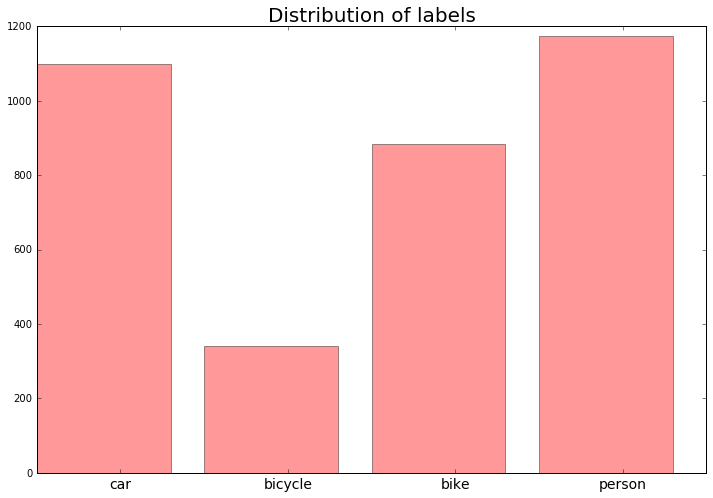

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [10]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [11]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [12]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, int(im.shape[1] * self.xi))
        yi = max(0, int(im.shape[0] * self.yi))
        xf = min(im.shape[1], int(im.shape[1] * self.xf))
        yf = min(im.shape[0], int(im.shape[0] * self.yf))
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [813]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.shape[0], batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.shape[0] - i)):
            objs = annotations[i+j]
            im = imread(objs[0]['image'])
            old_size = im.shape
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [750]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j]
                im = imread(objs[0]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = 1.
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .3 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [15]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [16]:
S = (7,7)
B = 2
C = 4

In [17]:
num_epochs = 1000
batch_size = 50

In [991]:
# Xtest,ytest = [t for t in generate_data_2(train_annotations[:1], C, batch_size=batch_size)][0]
Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)

In [992]:
net = {}
net['input'] = InputLayer((None,3,200,200), input_var=Xtest)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (3,3))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))


net['dense1'] = DenseLayer(dropout(net['pool4'], p=.7), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.1), (2 * 5 + 4) * (7*7), nonlinearity=None)
net['output'] = DenseLayer(dropout(net['dense2'], p=.0), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [878]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [993]:
net['output'] = net['dense2']
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [994]:
load_weights = True
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [995]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [996]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

In [ ]:
cost = yl._get_cost_optim_multi(yl.output, ytest, S, B, C)

> /usr/local/python/bnr_ml/objectdetect/yolo.py(252)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) cost.eval()
array(15.526830673217773)
(Pdb) obj_for_cell.shape.eval()
array([1, 5, 2, 7, 7])


In [946]:
train_loss, test_loss = yl.train(
    generate_data_2(train_annotations, C, batch_size=batch_size),
    generate_data_2(test_annotations, C, batch_size=batch_size),
    lr=2e-6,
    epochs=num_epochs
)

Getting cost...
> /usr/local/python/bnr_ml/objectdetect/yolo.py(252)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/yolo.py(252)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) c
Creating cost variable took 1.6198 seconds
Compiling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Compiling functions took 26.3124 seconds
Beginning training...
13.9733520508
15.9333752441
13.1038793945
13.8358666992
12.6292028809
15.2672546387
13.8595117187
12.3896374512
13.0353295898
12.3601599121
13.4589123535
13.9404382324
14.0831811523
11.8255310059
12.8962609863
14.4060400391
14.2090234375
11.6720178223
11.7833850098
12.4141259766
16.0645983887
11.7892504883
13.535045166
13.4650671387
14.8455236816
13.5293713379
12.4726367187
12.8609204102
12.4270812988
14.0257568359
16.5906689453
13.0295471191
16.0342248535
15.6352722168
13.3354748535
13.5426443917


  0%|          | 1/1000 [02:02<33:55:40, 122.26s/it]

Epoch 0
------
Train Loss: 13.6183, Test Loss: 18.0642
13.809407959
15.1201037598
13.4236816406
13.5222766113
13.2721069336
14.8018432617
13.9119091797
13.0518969727
11.950045166
12.2889855957
13.2885620117
13.4162475586
14.0810192871
12.568236084
12.6922619629
14.3550317383
13.9866223145
11.2752453613
11.7361816406
12.7203942871
16.2124475098
12.3951928711
13.73296875
13.4877331543
14.8353393555
13.4821142578
13.2663793945
12.5841906738
12.4778991699
13.5990087891
16.966809082
13.9614477539
15.9033972168
15.7213378906
13.1155541992
13.7063956124


  0%|          | 2/1000 [02:33<26:18:56, 94.93s/it] 

Epoch 1
------
Train Loss: 13.6311, Test Loss: 17.9363
13.8645251465
15.4171228027
13.4988500977
14.1986108398
12.8459411621
14.6931542969
13.7986108398
12.1395947266
12.6448193359
12.7571264648
13.2966149902
13.1245605469
13.9950927734
11.5344665527
12.8128271484
14.4775854492
14.4577172852
11.4053662109
11.329654541
12.391706543
16.5182470703
12.1819458008
13.7156445312
13.3676000977
14.5161767578
13.5797607422
12.8258557129
12.7399157715
12.5413623047
14.04796875
17.3553979492
13.8699401855
15.6683679199
15.5492663574
12.9073669434
13.4629045759


  0%|          | 3/1000 [03:04<20:59:17, 75.78s/it]

Epoch 2
------
Train Loss: 13.5981, Test Loss: 17.9527
14.2489916992
15.3590844727
13.6622521973
14.5755578613
12.7181201172
14.9339794922
13.9056640625
12.6225671387
12.6594238281
12.8840380859
13.3703491211
13.290690918
14.156953125
11.9646069336
12.6341223145
14.4897753906
14.1432336426
11.6022143555
11.6698217773
12.6837695313
16.4828686523
12.2896142578
14.1149145508
13.260546875
14.7326623535
13.2195544434
13.2509765625
12.845736084
12.1348388672
13.2493554688
17.1674853516
13.7281054687
15.289954834
16.4411462402
13.0422424316
13.8953029088


  0%|          | 4/1000 [03:35<17:15:36, 62.39s/it]

Epoch 3
------
Train Loss: 13.6867, Test Loss: 17.9425
13.5320812988
15.0041809082
13.4783105469
13.9715014648
12.7975402832
15.5238366699
14.0880273437
12.6231262207
12.2210705566
11.9071154785
13.3050244141
13.112857666
14.6835583496
12.0065319824
12.8936938477
13.7973681641
14.7203942871
11.1414599609
12.0520495605
12.0102270508
16.519387207
12.2767260742
14.2153466797
13.4782067871
14.960904541
13.6273510742
13.3931884766
12.8524902344
11.9240991211
13.5123925781
17.1815393066
13.8150610352
15.5703662109
16.4118103027
13.0806103516
13.2279331752


  0%|          | 5/1000 [04:06<14:39:03, 53.01s/it]

Epoch 4
------
Train Loss: 13.6366, Test Loss: 17.9702
13.5696643066
15.3399279785
13.3639892578
13.9383642578
12.3693847656
15.5714477539
14.3581506348
12.1753723145
12.6110742187
11.934375
13.7526342773
13.168503418
14.2206945801
11.8449890137
12.8657458496
14.0018408203
14.4531884766
11.4104785156
11.5707324219
12.6721801758
16.5978283691
12.1092456055
13.9618310547
13.2330456543
15.275020752
13.7096435547
12.8593505859
13.2247546387
12.3290380859
14.5717834473
16.664720459
13.0328051758
15.0175354004
15.9838647461
12.8838745117
13.4233904157


  1%|          | 6/1000 [04:37<12:49:25, 46.44s/it]

Epoch 5
------
Train Loss: 13.6131, Test Loss: 18.1300
13.6097216797
15.5872546387
13.7869458008
14.0512426758
13.0688806152
14.7465075684
13.3525708008
12.1334277344
12.9415673828
11.895526123
13.1201062012
13.6990454102
14.1212280273
12.309375
12.9362731934
14.8220922852
14.2032824707
11.442232666
11.2702856445
12.3146972656
16.7188000488
13.1353723145
14.1517346191
13.6329443359
15.0292675781
13.4236706543
13.2347265625
12.864786377
11.8393725586
13.634185791
17.2997644043
13.6635571289
15.0865197754
15.9129003906
12.6617016602
13.7285348075


  1%|          | 7/1000 [05:09<11:32:35, 41.85s/it]

Epoch 6
------
Train Loss: 13.6508, Test Loss: 18.0218
13.7557592773
15.7958984375
13.560378418
13.785534668
12.7137719727
14.797097168
14.2489550781
12.5635974121
12.3276513672
11.9421765137
13.6365844727
12.8616870117
14.0412719727
11.9586279297
12.6633764648
14.8063085937
13.7923718262
11.5971484375
12.4481750488
12.4898693848
16.3712426758
12.7573632813
13.2788659668
13.7801965332
14.2744128418
14.0385461426
13.0306164551
12.9669262695
12.7197290039
13.9797021484
17.3214367676
13.6104736328
15.8796569824
16.1266589355
13.0393896484
12.9717163086


  1%|          | 8/1000 [05:40<10:38:42, 38.63s/it]

Epoch 7
------
Train Loss: 13.6648, Test Loss: 17.9652
13.4513439941
15.6669958496
13.5124597168
14.1086120605
12.7084802246
15.0914013672
13.7544592285
12.4554150391
12.9618518066
12.8579077148
13.9447058105
13.3869958496
13.9449169922
12.0959094238
12.8951184082
14.1814172363
14.3186022949
11.3174755859
11.5480273438
12.518425293
16.843963623
12.5568798828
13.9745263672
13.2591186523
14.8848718262
13.6555334473
12.8083691406
11.9454199219
12.6217553711
13.4850024414
16.9264794922
14.1484289551
15.6308789063
15.7659814453
13.4384301758
13.9410627093


  1%|          | 9/1000 [06:11<10:00:51, 36.38s/it]

Epoch 8
------
Train Loss: 13.6835, Test Loss: 17.9670
13.5301318359
15.7659436035
13.2195812988
13.5605419922
12.6669494629
14.878848877
14.4404541016
12.4562231445
12.451895752
12.8329492188
13.2928137207
13.7216125488
14.3953674316
11.7881066895
12.693425293
13.8225830078
14.260090332
11.7102954102
11.3828161621
12.2796936035
16.3844226074
12.5042578125
14.1428710937
13.5424633789
15.126796875
13.3140820313
13.1324926758
12.7353820801
12.2546533203
14.2576330566
16.7334692383
13.7060888672
15.0344689941
15.9279711914
12.598034668
13.1575901576


  1%|          | 10/1000 [06:42<9:34:16, 34.80s/it]

Epoch 9
------
Train Loss: 13.6029, Test Loss: 17.9783
13.8917236328
15.1808435059
13.3587451172
13.9170788574
13.131739502
15.2122094727
13.6270849609
12.2639758301
12.7119995117
11.9281835937
13.417331543
13.1272570801
14.4059069824
11.9669274902
12.3871813965
14.1305200195
14.0557702637
11.2599084473
11.5104711914
12.2771972656
17.0521459961
12.1808740234
13.9106604004
13.2151245117
14.718137207
13.8760974121
13.1935180664
12.511541748
12.179329834
13.6482202148
17.23078125
13.0373596191
14.8729785156
16.3799206543
13.1238134766
13.3558053153


  1%|          | 11/1000 [07:13<9:15:32, 33.70s/it]

Epoch 10
------
Train Loss: 13.5625, Test Loss: 17.9393
13.8346655273
14.9611425781
14.1216650391
14.1352258301
13.1070275879
14.8383740234
13.6748986816
13.1003601074
12.7960510254
12.5228540039
13.2045251465
13.1571081543
13.9857531738
11.5848217773
12.4680847168
13.9839733887
14.1375598145
11.3062988281
11.7456433105
12.1309814453
16.2526904297
12.5832531738
13.7759960938
13.3618066406
14.5261157227
13.1586535645
13.2111975098
12.6835070801
12.6342797852
13.4658789062
17.0121850586
13.6270385742
15.3981323242
16.2481860352
12.8627575684
13.7017874581


  1%|          | 12/1000 [07:44<9:02:15, 32.93s/it]

Epoch 11
------
Train Loss: 13.5917, Test Loss: 18.0111
13.7917163086
15.2561633301
13.3632495117
13.3271374512
13.213638916
15.1011169434
14.3808349609
12.2208227539
12.1285961914
12.2707775879
13.461685791
13.3616259766
14.3935009766
11.9449133301
12.8878417969
13.6937011719
14.459005127
11.3514990234
11.8012133789
12.3493615723
15.93078125
12.2121289062
14.2251806641
13.4851708984
14.981484375
13.4211523438
12.8573596191
12.9397094727
11.5918969727
13.7321130371
17.2807519531
14.3019287109
15.3101940918
16.0102319336
13.2554675293
13.8743286133


  1%|▏         | 13/1000 [08:15<8:52:49, 32.39s/it]

Epoch 12
------
Train Loss: 13.6158, Test Loss: 17.9176
13.9525415039
15.5353222656
12.7781542969
13.5893920898
12.3756567383
15.2857495117
13.6843725586
12.2732763672
13.1064147949
12.3202868652
13.9633666992
13.1409619141
14.3018676758
11.6142260742
12.4407092285
13.9225
14.2490283203
11.3616210937
11.7413110352
12.847232666
15.9721643066
12.1204528809
13.5468127441
14.0078259277
15.045255127
14.0054614258
12.7041821289
12.9865856934
12.0992993164
13.8673425293
16.8796362305
13.1512658691
15.6061645508
15.9926123047
13.4874804688
13.4722394671


  1%|▏         | 14/1000 [08:46<8:46:05, 32.01s/it]

Epoch 13
------
Train Loss: 13.5952, Test Loss: 18.0470
13.4660534668
15.3957617188
13.4800134277
13.7386230469
13.2948522949
14.766439209
13.9840429687
12.7193017578
12.816796875
12.4706567383
13.6369995117
13.3478967285
13.6975463867
11.4348474121
12.3776208496
14.0176721191
14.2353271484
11.3322973633
11.3472387695
12.2562548828
16.1104443359
11.8490332031
13.8366955566
13.2033483887
14.7689562988
14.792869873
12.9349621582
12.9238354492
11.7232385254
13.886607666
17.0534338379
13.2385009766
15.4183654785
15.9827563477
13.1745385742
13.0335510254


  2%|▏         | 15/1000 [09:18<8:41:10, 31.75s/it]

Epoch 14
------
Train Loss: 13.5485, Test Loss: 17.8311
13.5704748535
15.4975317383
13.4277856445
13.6052978516
12.7209289551
15.125859375
14.1322875977
12.4977197266
11.9772570801
12.8743408203
13.1627807617
13.2826159668
14.3137768555
12.0498583984
12.7448950195
14.2601672363
14.3547924805
11.5377160645
11.5729553223
12.2694689941
16.1619726563
11.6722888184
13.4870617676
13.134128418
14.7566418457
13.7523571777
13.6845751953
13.2880395508
12.4555480957
13.2394799805
16.9501831055
13.0715429688
15.5396350098
15.446776123
12.7450378418
12.5810459682


  2%|▏         | 16/1000 [09:49<8:37:34, 31.56s/it]

Epoch 15
------
Train Loss: 13.5262, Test Loss: 17.9236
13.4694995117
15.5485058594
13.468996582
13.9171850586
12.8072802734
14.8025524902
14.1200292969
12.1282080078
12.4281787109
12.3326220703
13.2298718262
12.7696337891
14.1655773926
11.9596008301
12.4543457031
14.5805371094
14.0326208496
11.2494445801
11.5225061035
12.19171875
15.779777832
13.0695397949
14.0056994629
12.6958947754
14.9320922852
13.6142492676
12.5038427734
13.652791748
12.4702941895
14.352109375
17.0721362305
13.7989453125
15.2981494141
16.3075695801
13.0362072754
13.0884155273


  2%|▏         | 17/1000 [10:20<8:34:57, 31.43s/it]

Epoch 16
------
Train Loss: 13.5794, Test Loss: 17.8796
13.317388916
15.7918237305
13.2461047363
13.6680871582
13.040279541
15.1615222168
14.1871887207
12.4770556641
12.1979443359
13.0460974121
13.542043457
13.2259057617
14.1827368164
12.2373120117
12.4611560059
13.954765625
13.9391308594
11.1400512695
11.8746655273
13.1008447266
16.5700292969
12.458770752
13.733671875
13.9195751953
15.1106066895
13.7891760254
12.9586010742
12.6200622559
11.7654406738
13.5712756348
17.1990551758
13.2031030273
15.8313427734
15.7026086426
12.7610998535
13.8651942662


  2%|▏         | 18/1000 [10:51<8:32:53, 31.34s/it]

Epoch 17
------
Train Loss: 13.6348, Test Loss: 17.7992
13.4018371582
15.3491247559
13.3274597168
13.6395727539
12.3577026367
14.5689208984
13.6392333984
12.084609375
12.1516015625
11.9194299316
13.716550293
12.9785766602
14.2418896484
11.557644043
12.5891125488
14.2109667969
14.2239050293
11.8128979492
11.7827587891
12.5007751465
16.5597045898
11.809017334
13.9037451172
13.3546594238
14.7018652344
13.813651123
12.8979772949
13.5227270508
12.0500354004
14.1056933594
16.5085473633
13.4316186523
15.4245166016
15.8459228516
12.8106982422
13.4524117606


  2%|▏         | 19/1000 [11:22<8:31:20, 31.27s/it]

Epoch 18
------
Train Loss: 13.5069, Test Loss: 17.9166
13.273269043
15.5825256348
12.9334741211
13.384876709
13.1064135742
14.3477709961
13.965859375
12.6685058594
12.0866540527
12.1335803223
13.193482666
13.6388085937
13.519753418
12.2607531738
12.9328710938
14.3006994629
14.3406274414
11.4422509766
11.5751074219
12.4266186523
16.0398059082
11.8392114258
13.4795556641
13.3877404785
14.8978869629
13.5488891602
12.4534729004
12.9240405273
11.9357006836
14.4335705566
16.6984375
14.5099060059
15.5261157227
15.4207324219
12.6901611328
13.0379935128


  2%|▏         | 20/1000 [11:53<8:30:03, 31.23s/it]

Epoch 19
------
Train Loss: 13.4983, Test Loss: 17.9932
13.2828967285
14.6973266602
13.1824658203
13.89875
12.5510510254
14.8358081055
13.9129394531
12.9159973145
12.5205908203
12.0684204102
13.1155456543
13.7546191406
13.7925646973
11.8397351074
12.3417797852
13.9067358398
13.9371362305
11.5957214355
11.8001953125
12.4312011719
16.5620568848
12.0421105957
13.7510351562
12.964041748
14.6607800293
13.7612060547
12.1318493652
12.7881713867
12.4478918457
14.3351391602
16.4339892578
14.1113232422
15.5112792969
15.9616479492
13.3384423828
14.1518066406


  2%|▏         | 21/1000 [12:24<8:28:59, 31.19s/it]

Epoch 20
------
Train Loss: 13.5371, Test Loss: 17.9922
13.799486084
15.3546655273
13.6271594238
13.9231872559
12.6064648438
14.9349414062
14.2860095215
12.4039990234
11.9462353516
12.3859313965
13.7044921875
13.9597741699
14.5863537598
12.341072998
12.7617028809
13.5991809082
14.2216149902
11.511072998
11.71265625
12.2227282715
16.5024926758
11.6184277344
13.761640625
13.6193798828
14.7827294922
13.7831689453
12.2445007324
13.1827587891
12.1520385742
13.4735400391
17.0851855469
13.411640625
15.5486608887
15.8377172852
12.7039538574
13.4285042899


  2%|▏         | 22/1000 [12:55<8:28:09, 31.18s/it]

Epoch 21
------
Train Loss: 13.5840, Test Loss: 18.0671
13.3320007324
15.4699438477
13.1232727051
13.3926306152
12.9163342285
14.8742736816
14.4004260254
12.4140393066
12.4531018066
12.7087060547
13.016003418
13.0143554688
13.8764428711
11.5685009766
12.7263574219
14.0467272949
13.8957165527
11.2759765625
11.9458508301
12.1821679688
16.3611376953
11.8688549805
13.7688952637
13.7271350098
14.7959509277
13.7212084961
12.505123291
12.8743164062
12.3906030273
13.3379016113
16.8628979492
13.6838439941
15.8985717773
15.9442248535
13.0700219727
13.1007455008


  2%|▏         | 23/1000 [13:27<8:27:22, 31.16s/it]

Epoch 22
------
Train Loss: 13.5151, Test Loss: 17.8179
13.6779785156
15.0807189941
13.4313342285
13.8632189941
12.9024487305
15.3702624512
13.7259692383
12.5043041992
12.4132263184
11.7348828125
13.4055395508
13.1183666992
13.9883361816
11.8522216797
12.5556738281
14.0820654297
14.2964440918
11.950916748
11.589074707
12.5606408691
16.6583227539
12.2047814941
13.7773730469
13.4778942871
15.1931689453
13.5670397949
13.2968078613
12.0083886719
11.8808618164
14.1718981934
16.4505969238
13.512253418
14.9449108887
16.370736084
12.7273278809
13.3275338309


  2%|▏         | 24/1000 [13:58<8:26:39, 31.15s/it]

Epoch 23
------
Train Loss: 13.5465, Test Loss: 18.0173
13.7017993164
15.8134753418
13.3421228027
13.8704492188
12.6398950195
15.276706543
13.8523303223
12.0470898437
12.5183154297
12.1265429687
13.0897021484
13.0621972656
14.0162719727
12.0225866699
12.5119262695
13.6205322266
13.7890429687
10.7946435547
11.6470556641
12.396730957
15.99203125
12.6777026367
13.6526000977
13.5420239258
14.7383068848
13.8360266113
12.5292858887
13.2799182129
12.3822216797
13.7263806152
16.8141101074
14.0623925781
15.1675366211
16.0307568359
12.534432373
13.767061942


  2%|▎         | 25/1000 [14:29<8:26:01, 31.14s/it]

Epoch 24
------
Train Loss: 13.5242, Test Loss: 17.9451
13.6310668945
14.8559155273
13.1167224121
13.9224951172
12.6515087891
14.9265808105
13.464239502
12.9234423828
12.0686206055
12.5006921387
13.7081311035
13.9170178223
14.4503039551
12.0541931152
13.204342041
14.2308410645
13.6410302734
11.0617150879
11.2689147949
12.1155944824
16.2720666504
12.6738183594
14.2681469727
13.0787072754
14.7328881836
13.6488781738
12.7086401367
12.3232312012
11.8415881348
13.4642956543
16.842890625
13.3302209473
15.3731079102
15.8854382324
12.8686462402
13.9457650321


  3%|▎         | 26/1000 [15:00<8:25:28, 31.14s/it]

Epoch 25
------
Train Loss: 13.5270, Test Loss: 17.8850
13.5175378418
15.3052709961
13.4949926758
14.1409594727
13.1568029785
14.9526025391
14.0211779785
12.2887341309
12.1924023438
11.9994042969
13.3630993652
13.1188134766
13.9638500977
11.6869726562
13.003182373
13.8549145508
13.9687902832
11.101739502
11.3847827148
11.9270947266
16.0543896484
12.275078125
13.6168518066
13.3661523438
14.7318383789
13.2587927246
11.9378881836
12.7903857422
11.7434960938
14.1812744141
16.9062609863
13.1538439941
15.6280749512
15.7891943359
12.975793457
12.9212411063


  3%|▎         | 27/1000 [15:31<8:24:57, 31.14s/it]

Epoch 26
------
Train Loss: 13.4382, Test Loss: 17.9471
13.3440026855
15.1529040527
13.0632470703
13.9298010254
12.3148864746
15.9321972656
14.2445007324
12.2977770996
12.1919836426
11.9499975586
13.8249536133
12.9481591797
13.7299938965
11.5436608887
12.3826879883
13.9871252441
13.7682373047
11.2214453125
11.621730957
12.3731445313
16.1768029785
12.2158959961
13.4034082031
13.420369873
14.8467028809
13.6286645508
13.3949389648
12.8272851562
11.703737793
14.6728063965
17.6268493652
13.8276196289
15.3393041992
15.6939990234
12.3358764648
13.8115199498


  3%|▎         | 28/1000 [16:02<8:24:22, 31.13s/it]

Epoch 27
------
Train Loss: 13.5208, Test Loss: 18.0322
13.4215100098
15.5585888672
13.7246020508
13.626027832
13.075402832
15.1491137695
13.827388916
12.7508776855
12.4278552246
11.8339257813
13.7138366699
12.7979748535
14.1987719727
11.6046362305
12.3829858398
13.6683630371
13.4349536133
11.6853955078
11.4775024414
12.4739587402
16.2934033203
11.7875634766
13.7932067871
13.1602441406
14.4348278809
14.0602514648
12.2331311035
12.8978869629
12.2455895996
13.5570800781
16.637890625
13.5310925293
15.5579187012
15.5486901855
12.5262805176
13.4274108887


  3%|▎         | 29/1000 [16:33<8:23:59, 31.14s/it]

Epoch 28
------
Train Loss: 13.4591, Test Loss: 17.9922
13.3095910645
14.9428845215
12.7181420898
14.018885498
13.0756933594
15.3826953125
13.5782104492
12.4819958496
11.9485620117
12.2883239746
13.6235522461
12.7096740723
14.0123925781
11.4894763184
12.6279138184
13.7729150391
13.874909668
11.4447412109
11.4157104492
12.030657959
16.2751000977
12.3463232422
13.2754943848
13.4337243652
14.3574951172
13.4173754883
13.0627929687
12.4895617676
12.2393078613
13.8554431152
16.7599853516
13.3996044922
15.6071057129
15.7424511719
12.9106384277
13.6415012905


  3%|▎         | 30/1000 [17:05<8:23:33, 31.15s/it]

Epoch 29
------
Train Loss: 13.4322, Test Loss: 17.9412
13.2453051758
15.3975878906
13.5373913574
13.8143469238
13.0633789062
15.334876709
13.5463757324
12.3332299805
12.0536193848
12.8736584473
13.152088623
13.1924951172
14.4419360352
11.7218249512
12.283215332
13.8098657227
14.029395752
11.6877160645
11.3057592773
12.2066662598
16.0411706543
12.453972168
13.7968737793
12.8892724609
14.1473376465
14.415300293
12.6796081543
12.8755090332
12.1778027344
13.8934790039
16.7559240723
13.4075231934
14.7944677734
15.582421875
12.3995922852
13.0531014579


  3%|▎         | 31/1000 [17:36<8:22:54, 31.14s/it]

Epoch 30
------
Train Loss: 13.4554, Test Loss: 18.0597
13.1852978516
15.2101123047
13.6275476074
13.7806933594
12.7563818359
14.4989550781
13.8332885742
12.4770141602
12.4708581543
12.5049023438
13.6813061523
12.7997668457
13.6295581055
12.2037060547
12.3698352051
14.5461547852
14.0200292969
11.3787231445
11.0616333008
12.1656677246
16.0770751953
12.4952929688
13.5177758789
13.4805773926
14.3842382812
13.7375830078
12.6789758301
12.7196362305
12.2706335449
13.8508239746
16.716126709
13.3226879883
15.2107470703
15.5906896973
12.7850061035
12.7542977469


  3%|▎         | 32/1000 [18:07<8:22:22, 31.14s/it]

Epoch 31
------
Train Loss: 13.4387, Test Loss: 17.9376
13.5949768066
15.8142736816
13.5465332031
12.9588012695
12.6969116211
14.493067627
13.8814404297
11.961907959
12.1039013672
11.7256201172
14.2358349609
13.4383972168
14.0691357422
11.8119726562
12.6994714355
14.3063317871
13.7832849121
11.1428125
11.399375
12.7364013672
16.5878625488
13.1893579102
13.4373156738
13.3537182617
14.4049560547
13.9412207031
12.2227233887
12.6234472656
12.4490637207
13.1337817383
17.1528930664
13.4128735352
15.5696130371
16.0974645996
12.5729089355
12.9983398437


  3%|▎         | 33/1000 [18:38<8:21:45, 31.13s/it]

Epoch 32
------
Train Loss: 13.4874, Test Loss: 17.9455
13.347232666
15.0871533203
12.994473877
13.4404577637
13.0909912109
14.503527832
13.5522900391
12.2857104492
12.5623547363
12.0996398926
12.9448071289
12.9363977051
14.1995166016
11.8825854492
12.569083252
13.9835888672
14.4628588867
11.3396813965
11.946138916
12.3119763184
16.6910595703
12.8940136719
13.4194018555
13.572956543
14.88390625
13.4631896973
12.7716247559
12.9414904785
11.9411779785
14.1003942871
15.9189465332
13.3087817383
15.4027539063
16.0036474609
12.7283605957
13.3231776646


  3%|▎         | 34/1000 [19:09<8:21:14, 31.13s/it]

Epoch 33
------
Train Loss: 13.4696, Test Loss: 17.9697
13.6920288086
15.2194946289
13.0309887695
13.6210961914
13.5502075195
14.756817627
14.2612475586
12.4113000488
12.2740759277
11.859720459
14.0532006836
12.8326965332
13.6224230957
11.9842236328
12.4948974609
13.9826513672
14.0194592285
11.3437658691
11.9907849121
12.3063061523
16.5466589355
12.1825598145
13.9488452148
13.3826306152
15.1281115723
14.7286499023
12.9377648926
13.0630236816
11.5991967773
13.5909301758
16.4841723633
13.6024707031
14.9178820801
15.956809082
12.3087890625
14.2391444615


  4%|▎         | 35/1000 [19:40<8:20:44, 31.13s/it]

Epoch 34
------
Train Loss: 13.5535, Test Loss: 17.8257
13.3500598145
15.5067236328
13.2703503418
13.3549755859
12.8327648926
14.7133813477
14.0671679688
12.4787390137
13.299744873
12.6458227539
13.0907458496
12.9099621582
14.1876171875
12.1544348145
12.4329309082
14.3889453125
13.7605212402
11.2478601074
11.4951696777
12.3007080078
16.5063305664
12.0751159668
13.3720507812
12.919954834
14.6447485352
13.3589624023
12.9181945801
12.8236035156
11.8057507324
13.6020178223
16.7518066406
13.3262182617
16.0365136719
15.8057202148
12.8097229004
13.3920540946


  4%|▎         | 36/1000 [20:11<8:20:12, 31.13s/it]

Epoch 35
------
Train Loss: 13.4899, Test Loss: 18.1408
13.0936877441
14.7125952148
13.7251611328
13.4006359863
12.7620947266
14.4325964355
13.8903710937
12.6750256348
12.5165148926
12.287376709
13.3484741211
13.0122155762
13.9420532227
12.0424768066
12.053927002
14.2833776855
14.2520349121
11.3748730469
11.470567627
12.0628967285
16.3149267578
12.6891064453
13.6622705078
13.4415124512
15.0182592773
14.0089257812
12.7799182129
12.6390197754
11.7289807129
13.3002453613
16.6878601074
13.4471057129
15.5444799805
15.4273718262
12.7482324219
12.6374084473


  4%|▎         | 37/1000 [20:42<8:19:39, 31.13s/it]

Epoch 36
------
Train Loss: 13.4282, Test Loss: 17.9190
13.0734521484
15.7114245605
13.0981005859
13.8655224609
12.3713012695
14.5734729004
13.6970996094
12.7519702148
12.3058850098
11.7985510254
13.9108996582
13.0170336914
14.0679455566
11.3124755859
12.0378112793
13.4498547363
14.2936657715
11.7595703125
11.5742626953
12.7520043945
15.8164770508
11.8480761719
14.0061022949
13.0585107422
14.3996630859
13.9277526855
12.6921704102
13.0460620117
11.9679504395
13.8254052734
16.6270593262
13.8662011719
15.4030895996
15.796114502
12.2330981445
13.1723606655


  4%|▍         | 38/1000 [21:14<8:19:02, 31.13s/it]

Epoch 37
------
Train Loss: 13.4197, Test Loss: 17.9370
12.8825366211
14.8794458008
13.351328125
13.2921105957
12.8490600586
14.8374133301
13.8235437012
12.0961022949
12.4053198242
11.9555615234
12.943013916
13.3867004395
14.3944506836
11.8695043945
13.1977502441
13.2941650391
13.8149291992
11.7433325195
11.4940576172
12.448963623
16.1229992676
11.8572143555
14.0431359863
13.8034191895
15.3582067871
13.5297436523
12.4833972168
12.2150097656
11.6059899902
14.0688317871
16.2211999512
13.5860070801
15.2313879395
15.550637207
12.6477770996
13.7284223284


  4%|▍         | 39/1000 [21:45<8:18:30, 31.12s/it]

Epoch 38
------
Train Loss: 13.4170, Test Loss: 17.8423
13.7190283203
15.0652783203
13.2367224121
13.4854968262
12.3788171387
14.6516711426
13.9745495605
12.3185412598
12.636751709
12.3451867676
13.4684130859
13.1498156738
13.8371899414
11.6035009766
12.7164245605
14.0831958008
14.1639538574
11.4343933105
11.4383618164
12.3905395508
16.220201416
11.6859619141
13.7058642578
13.2822473145
14.3485253906
13.567265625
12.9592492676
12.4971948242
11.970291748
13.3965649414
16.5216967773
12.7694628906
14.8810632324
15.7662280273
13.5079052734
13.0366969517


  4%|▍         | 40/1000 [22:16<8:18:00, 31.13s/it]

Epoch 39
------
Train Loss: 13.3948, Test Loss: 18.0050
12.7375732422
15.5427514648
12.6939282227
13.2964221191
12.4488330078
14.9977978516
13.4638708496
12.3983947754
12.5556201172
12.5724487305
13.8420825195
13.0288476563
14.7853820801
12.1800756836
12.614119873
13.6428686523
14.3981115723
11.752833252
12.1991394043
12.8078381348
16.649152832
12.5001342773
13.7096264648
13.6763085938
14.5559643555
13.4954748535
12.6238574219
12.5590466309
12.5863317871
14.1191455078
15.7839050293
13.4751818848
15.725378418
14.9635656738
12.8844519043
12.9786778041


  4%|▍         | 41/1000 [22:47<8:17:30, 31.13s/it]

Epoch 40
------
Train Loss: 13.5068, Test Loss: 17.8323
12.974354248
15.0176403809
13.3808728027
14.0277404785
13.0416491699
14.918894043
13.7196691895
12.4447424316
11.8648657227
12.4388427734
13.284005127
12.314185791
14.3247998047
12.0585217285
12.0856323242
14.8010229492
14.0239794922
11.3472021484
11.0675292969
12.2497229004
16.1716125488
12.098425293
13.2676928711
13.195982666
14.5553442383
13.9631750488
12.548380127
12.8053808594
12.1894714355
13.5929858398
16.4636499023
13.0833300781
14.9811169434
15.468449707
12.8835192871
12.9484889439


  4%|▍         | 42/1000 [23:18<8:16:59, 31.13s/it]

Epoch 41
------
Train Loss: 13.3779, Test Loss: 17.8534
13.2918237305
15.2556188965
12.9808935547
13.7091687012
12.2680822754
15.0110522461
13.6883105469
12.663190918
12.2476391602
11.7088354492
12.9942480469
12.7697741699
14.3984179687
11.2402563477
12.3378723145
13.8363085937
13.8345239258
11.2758007813
11.0559912109
12.5441125488
16.1373840332
12.1293139648
13.8649780273
12.8928918457
14.2798022461
13.6456604004
12.9584997559
12.0570874023
11.9264428711
14.6595410156
17.0586791992
13.2906860352
16.068314209
15.820604248
12.3801647949
13.2510314941


  4%|▍         | 43/1000 [23:49<8:16:24, 31.12s/it]

Epoch 42
------
Train Loss: 13.3759, Test Loss: 17.8251
13.3516418457
15.3362023926
13.1598144531
14.7199731445
12.6303515625
15.3744104004
13.8728063965
12.4913964844
12.7297119141
12.0670483398
13.0327197266
12.5020581055
13.9712524414
11.4234741211
12.7459057617
13.8261230469
13.8018261719
11.7136303711
11.3000170898
12.2725793457
15.7786535645
11.6695129395
13.7629797363
12.7923132324
14.8456384277
13.4447973633
12.5292199707
12.9755187988
12.1300439453
13.1079968262
16.5298474121
13.2714941406
14.6387365723
15.9286450195
12.2457250977
13.0415727888


  4%|▍         | 44/1000 [24:20<8:15:51, 31.12s/it]

Epoch 43
------
Train Loss: 13.3615, Test Loss: 17.8968
13.4974353027
14.8244750977
12.9965612793
13.6068041992
12.5152832031
15.4123217773
13.7870568848
11.7318066406
12.3599316406
12.4138806152
13.5964477539
13.283536377
14.3621289062
12.2275744629
12.7855395508
13.6520800781
13.9778417969
11.1782409668
11.5231384277
12.2750476074
15.9971655273
11.8351123047
13.3497485352
13.2020129395
14.6077429199
13.1273376465
12.3139453125
12.7682556152
11.613939209
13.6814123535
16.4997790527
13.173059082
15.178659668
15.9756274414
13.1712756348
13.4895098005


  4%|▍         | 45/1000 [24:51<8:15:21, 31.12s/it]

Epoch 44
------
Train Loss: 13.3887, Test Loss: 17.7711
13.4750720215
15.1501098633
13.1600061035
14.1140637207
12.6670922852
14.6448205566
13.2926220703
12.4310168457
11.9756469727
11.9174719238
12.9068151855
12.911875
13.9281115723
11.5565161133
12.7696435547
14.3350341797
13.7628137207
11.6670568848
11.7349609375
12.7428039551
16.3353942871
11.7298522949
13.7940649414
13.4412133789
14.7509204102
12.9013818359
12.5558435059
12.9291223145
11.7870812988
13.3456774902
16.6181811523
13.0624267578
15.5515002441
15.2659912109
12.3851281738
12.772253418


  5%|▍         | 46/1000 [25:23<8:14:51, 31.12s/it]

Epoch 45
------
Train Loss: 13.3436, Test Loss: 17.9624
12.9572277832
14.7281152344
13.227635498
13.5208105469
13.2036108398
14.9624780273
13.6375317383
12.4537145996
12.5431591797
11.8621337891
13.2512915039
12.7569543457
14.7291210938
11.6125170898
12.8762316895
13.8783728027
14.2928039551
11.3443896484
11.7226550293
12.487598877
16.0841894531
11.4406860352
13.3107470703
12.6918334961
14.367467041
13.8485498047
13.3217382812
12.2013244629
11.783137207
13.1322460938
17.4184765625
14.954765625
15.613470459
15.7108789063
12.860760498
12.5842459542


  5%|▍         | 47/1000 [25:54<8:14:17, 31.12s/it]

Epoch 46
------
Train Loss: 13.4270, Test Loss: 17.9962
12.9873449707
15.3587646484
13.2217700195
13.5977514648
12.8624536133
15.1547424316
13.6091906738
12.2724316406
12.3711132813
11.8138269043
13.7174890137
13.1521618652
13.4173413086
12.0626013184
13.0705151367
13.8196691895
13.9935546875
11.1994274902
11.4457739258
12.1299389648
15.7738916016
11.744083252
12.9998352051
13.1816699219
14.4935339355
13.4008056641
12.6573278809
12.4088134766
11.4173486328
13.4299291992
16.1800817871
13.3821923828
15.4140710449
15.3984240723
13.9183557129
13.2592293876


  5%|▍         | 48/1000 [26:25<8:13:44, 31.12s/it]

Epoch 47
------
Train Loss: 13.3422, Test Loss: 18.0018
13.3272607422
16.4645153809
13.2681018066
13.1919055176
12.6970336914
14.8094152832
14.0738574219
12.5503735352
12.1378869629
12.249967041
13.3981811523
12.7917834473
13.5729528809
11.7508850098
12.5555615234
14.3629711914
14.4163793945
11.4701171875
11.5394091797
12.3306225586
16.2495263672
12.2936328125
14.0130993652
13.6208325195
14.9673364258
13.7292907715
12.7237353516
12.8637121582
12.2942651367
13.6640795898
15.9486108398
13.2915002441
15.5883398437
15.5666821289
12.3635913086
13.3927577427


  5%|▍         | 49/1000 [26:56<8:13:15, 31.12s/it]

Epoch 48
------
Train Loss: 13.4869, Test Loss: 17.9273
13.1542797852
14.9089685059
13.0698364258
13.8105236816
12.4204040527
15.1079321289
13.5057324219
12.7402355957
12.3926879883
12.0558422852
13.3732556152
12.6676928711
13.4058679199
12.4283728027
12.4620996094
13.5631201172
13.9143041992
10.9892431641
11.8963525391
12.3022436523
16.1764282227
11.7932092285
13.4511633301
12.9041674805
14.5501330566
13.9232397461
12.2825732422
12.4382263184
12.0110400391
13.880111084
16.9544897461
13.7442114258
15.6703149414
15.4334008789
12.4190087891
12.7357535226


  5%|▌         | 50/1000 [27:27<8:12:48, 31.12s/it]

Epoch 49
------
Train Loss: 13.3482, Test Loss: 17.7980
13.0621679687
15.4085473633
13.0793859863
14.2496276855
12.5575134277
14.8236486816
13.4974475098
12.1641577148
12.2760144043
11.8105151367
13.3721203613
13.1882092285
13.781015625
11.4225537109
12.4906652832
13.6630334473
13.8634765625
11.1069506836
11.4980993652
12.9946252441
16.235201416
12.6708447266
13.2562158203
13.6207312012
14.5273120117
13.6154101563
12.5562792969
12.4053503418
11.5663696289
13.6650158691
17.4645288086
14.16296875
15.3055651855
15.5104785156
12.2405688477
12.7851222447


  5%|▌         | 51/1000 [27:58<8:12:17, 31.12s/it]

Epoch 50
------
Train Loss: 13.3860, Test Loss: 17.8584
13.5704077148
15.2311157227
12.8805456543
13.8231628418
12.3810656738
14.8300817871
13.8315087891
11.792019043
12.1135021973
11.2598852539
13.4466821289
12.9431005859
14.3309130859
11.2573962402
12.3700439453
13.3143103027
13.9096704102
11.0171374512
11.2943969727
12.008215332
16.2282568359
12.0972875977
13.699753418
12.8333361816
14.4302502441
13.5786816406
12.7152685547
12.3967114258
12.3475244141
13.2334191895
15.8861645508
12.7148254395
15.4848242187
15.5735290527
12.9008789062
13.1604195731


  5%|▌         | 52/1000 [28:29<8:11:45, 31.12s/it]

Epoch 51
------
Train Loss: 13.2468, Test Loss: 17.8166
13.3015698242
15.1429455566
12.9934899902
13.3836865234
12.6315930176
15.0789233398
14.0913415527
12.132019043
12.0692260742
11.7894116211
13.3957275391
12.8105310059
14.3627539062
11.6990563965
12.6911523437
14.7323132324
13.5689709473
11.0358410645
10.8486547852
12.4043225098
15.4274169922
12.38875
13.0269763184
13.1763208008
14.7811779785
12.8649926758
12.6088891602
12.6309191895
11.9400244141
13.7709667969
17.5798730469
13.1111242676
14.8742456055
16.0760375977
12.1620214844
13.0344412667


  5%|▌         | 53/1000 [29:00<8:11:16, 31.13s/it]

Epoch 52
------
Train Loss: 13.3227, Test Loss: 17.9702
13.2479907227
14.7322705078
13.4053613281
13.8024523926
13.3800634766
14.9104626465
13.6466357422
12.2832861328
12.1977307129
12.7098242188
13.0983117676
12.8400463867
14.1955273437
11.4242114258
12.3535876465
13.8469995117
14.2621606445
11.410534668
11.4832775879
12.8470739746
16.226262207
12.0477502441
13.4181762695
12.963848877
14.6909375
13.1973583984
13.1394787598
12.4496057129
11.5668884277
13.8151550293
16.3472924805
13.3504443359
15.0440600586
16.6163439941
12.3661254883
13.3359139579


  5%|▌         | 54/1000 [29:32<8:10:46, 31.13s/it]

Epoch 53
------
Train Loss: 13.4070, Test Loss: 17.8821
13.1097900391
15.2463024902
13.0348730469
14.6311132813
12.5287768555
15.0833898926
13.6242053223
12.0598181152
12.6878979492
11.9065185547
13.5875341797
12.9596374512
13.9461474609
11.4428283691
12.4642907715
14.0683740234
14.1144177246
10.9697729492
11.0798400879
12.4113989258
15.7097058105
12.0996228027
13.4657214355
13.3774121094
14.6571325684
13.5788000488
12.497277832
11.9844311523
11.6701049805
13.041328125
16.2522619629
13.7239025879
15.0555480957
15.9597912598
12.7221118164
13.0724775042


  6%|▌         | 55/1000 [30:03<8:10:13, 31.13s/it]

Epoch 54
------
Train Loss: 13.3285, Test Loss: 17.9033
13.5272631836
15.8169177246
12.9586425781
13.4667175293
12.7645263672
14.510637207
14.2368383789
11.9311108398
12.288293457
11.9575305176
13.2298950195
12.6580419922
13.498729248
11.2285229492
12.1840686035
13.8520788574
13.852388916
11.3312109375
11.5218359375
11.9509130859
16.1529443359
11.9823120117
13.586965332
13.1767687988
15.1248571777
13.5002075195
12.3332336426
12.7250634766
11.2567236328
13.4182080078
17.0235559082
13.5801745605
14.852878418
15.6338537598
12.8686999512
12.7693132673


  6%|▌         | 56/1000 [30:34<8:09:46, 31.13s/it]

Epoch 55
------
Train Loss: 13.2987, Test Loss: 17.9398
13.3444885254
14.9973217773
12.9981054687
13.629119873
12.5158081055
14.7554772949
13.7290356445
12.528112793
12.0423364258
12.3277099609
12.9155395508
12.3554980469
13.4350134277
11.8078051758
12.345612793
13.508548584
14.1100231934
11.2101037598
11.4092565918
12.2230895996
16.1265759277
11.9721679688
13.2291674805
13.0708813477
14.0512329102
13.5455187988
12.6019091797
12.6218774414
11.4968945312
13.4051147461
16.6150683594
13.2296350098
14.9132177734
15.425592041
12.158104248
13.308278983


  6%|▌         | 57/1000 [31:05<8:09:10, 31.12s/it]

Epoch 56
------
Train Loss: 13.2211, Test Loss: 17.8962
12.675489502
15.2654394531
12.9867150879
13.5303515625
12.5652526855
14.6816125488
13.4786083984
11.9602685547
11.8513574219
12.0779467773
13.0620007324
12.9020202637
14.0286401367
11.7823242188
12.1603991699
13.511229248
13.6332165527
11.0998461914
11.3664367676
12.3224255371
16.4329724121
12.2086999512
13.6894091797
12.7958288574
14.9686230469
13.5591882324
12.7567883301
12.9970458984
11.740057373
13.4778747559
17.024786377
13.3057836914
15.2920715332
15.9542749023
12.9314465332
12.9045942034


  6%|▌         | 58/1000 [31:36<8:08:38, 31.12s/it]

Epoch 57
------
Train Loss: 13.3050, Test Loss: 18.0147
12.7479443359
14.8724462891
13.1272290039
13.4255297852
12.5021447754
14.3419030762
13.9728808594
12.2077490234
12.3722851562
11.8248388672
13.1465490723
13.0166088867
13.7772998047
11.9081835937
12.9471948242
13.5897106934
14.0895654297
11.2430957031
11.3211694336
11.5971569824
15.922623291
11.9249243164
13.6723876953
12.6792150879
14.6649316406
13.4221594238
11.7660400391
12.4377514648
11.5044995117
14.0109973145
17.1035620117
13.4878540039
15.2608288574
15.9126611328
12.2027575684
13.114074707


  6%|▌         | 59/1000 [32:07<8:08:10, 31.13s/it]

Epoch 58
------
Train Loss: 13.2533, Test Loss: 17.9364
13.6375170898
14.8659265137
12.8545275879
13.3602807617
12.6918457031
14.7247265625
14.1510632324
12.2094799805
12.201385498
12.2520397949
13.2953894043
13.1511474609
13.6877941895
11.6972009277
12.3195080566
13.7109472656
13.6463476563
11.3655322266
11.7644885254
12.3452124023
15.7318737793
12.4549304199
13.5359838867
13.3068945313
14.8081945801
13.2280493164
12.7877819824
12.0558752441
11.5943115234
14.1159838867
16.4919030762
13.5029138184
14.4549121094
15.848548584
12.1638000488
13.2540605818


  6%|▌         | 60/1000 [32:38<8:07:39, 31.13s/it]

Epoch 59
------
Train Loss: 13.3130, Test Loss: 17.9431
13.0350402832
15.5812255859
13.0920837402
13.0703198242
13.1665332031
14.8132470703
13.7553686523
11.8084716797
12.6828881836
12.1436291504
13.1686132812
12.9551586914
13.5510461426
11.8968786621
12.2057519531
13.6851062012
13.6360668945
10.7496691895
11.5810595703
12.3069238281
16.3869384766
11.5283166504
14.1147961426
13.0121411133
14.5784216309
13.6501049805
12.2817419434
12.0182324219
12.0353393555
13.2049365234
16.3280358887
12.519979248
15.1667382812
15.7946716309
12.4223205566
13.2655796596


  6%|▌         | 61/1000 [33:09<8:07:09, 31.13s/it]

Epoch 60
------
Train Loss: 13.2554, Test Loss: 17.8030
13.0849182129
14.7015185547
13.490970459
13.3111193848
12.7968005371
14.4882177734
13.781986084
12.6060766602
12.879552002
12.0878930664
13.2018481445
12.5737536621
14.1517419434
11.6401660156
11.9473254395
13.6394274902
13.5740234375
11.0132250977
10.6869262695
12.2254370117
15.6043933105
11.5300769043
13.4834130859
12.7390258789
14.4087219238
13.4269506836
12.5642297363
12.7235510254
11.8040490723
13.8347546387
16.9854016113
13.1719812012
15.340090332
16.1110827637
12.9293823242
13.4556501116


  6%|▌         | 62/1000 [33:41<8:06:38, 31.13s/it]

Epoch 61
------
Train Loss: 13.2777, Test Loss: 17.9222
12.718059082
14.7301000977
12.8761035156
13.7131115723
12.6232629395
14.2721325684
14.0116699219
12.8289697266
13.0929248047
12.1019396973
13.8183496094
12.8489819336
13.6561535645
11.6149523926
12.3240002441
13.6821325684
14.3200683594
11.4770544434
11.4539746094
12.1142236328
15.641270752
12.4615344238
13.1203613281
13.5522583008
14.2442895508
13.5389770508
12.1888952637
13.2516259766
11.6303735352
14.2118188477
16.4596679688
13.0830541992
14.7630444336
15.8329125977
12.2283679199
13.1724155971


  6%|▋         | 63/1000 [34:12<8:06:07, 31.13s/it]

Epoch 62
------
Train Loss: 13.3239, Test Loss: 17.9050
12.9288562012
14.8030126953
12.9383618164
12.9852734375
12.7770117187
14.1932653809
13.3743481445
11.7061352539
11.9239562988
11.7083129883
13.2994445801
12.944276123
13.5868212891
11.6534545898
11.9785620117
13.8543347168
13.8223022461
11.0856347656
11.4259643555
11.959753418
16.2849243164
12.0413049316
14.0323620605
13.453605957
14.8463769531
13.7314172363
12.4560681152
12.2642883301
11.485390625
13.2161450195
16.906159668
13.5882067871
14.6047668457
15.4664941406
12.5861499023
13.211050851


  6%|▋         | 64/1000 [34:43<8:05:35, 31.13s/it]

Epoch 63
------
Train Loss: 13.1979, Test Loss: 17.8918
12.864465332
14.4780383301
13.4155273438
13.1080773926
12.4838305664
14.812166748
13.5270458984
12.1956860352
12.250847168
11.4850830078
13.2771923828
12.9341540527
13.8991162109
11.7790710449
12.4252453613
13.8576647949
14.4250158691
10.8919812012
11.2402697754
12.0411791992
16.5522302246
11.4442272949
13.4340063477
13.3628552246
14.2190893555
13.26328125
12.6250610352
12.8857336426
11.8677661133
13.4381652832
16.7770483398
13.5345800781
15.0357128906
16.0809362793
13.0566516113
13.6143048968


  6%|▋         | 65/1000 [35:14<8:05:05, 31.13s/it]

Epoch 64
------
Train Loss: 13.2940, Test Loss: 17.9619
12.7302587891
14.9751257324
12.7092895508
13.6057983398
13.0331152344
14.5212182617
13.6554052734
11.781940918
12.3358813477
12.2432324219
12.9818896484
12.9915063477
13.5496618652
11.8297741699
12.0083520508
13.8740930176
14.1731970215
11.0233996582
11.4508435059
11.9205932617
15.8190600586
11.9395690918
13.2764123535
12.9728894043
14.5505444336
13.6149914551
12.0468249512
13.0902392578
11.5089453125
13.2844140625
16.3503381348
13.3146459961
15.1129382324
15.6121936035
12.3292651367
13.5764500209


  7%|▋         | 66/1000 [35:45<8:04:30, 31.13s/it]

Epoch 65
------
Train Loss: 13.2165, Test Loss: 17.9420
13.3562268066
15.5558959961
13.0938598633
13.5000683594
12.2813964844
14.1997143555
13.6040344238
12.2112194824
12.1632946777
11.8552404785
12.8991125488
13.4206555176
13.9301977539
11.6267285156
12.5533374023
13.5585095215
14.2115100098
11.2033557129
11.3411181641
12.9935693359
16.0280249023
12.3355371094
13.2678149414
13.4746972656
14.1219018555
13.2168725586
12.5822790527
12.5643688965
11.8501867676
13.5943835449
16.7835266113
12.9491479492
15.3589770508
15.5439306641
12.0863232422
12.7990914481


  7%|▋         | 67/1000 [36:16<8:03:59, 31.12s/it]

Epoch 66
------
Train Loss: 13.2810, Test Loss: 17.9546
13.3398852539
14.9869299316
13.6166723633
13.4060766602
12.5367419434
14.6615820312
13.7350732422
12.4937878418
11.9484155273
11.6283911133
13.02515625
12.4782653809
14.2193835449
11.5027294922
12.5480981445
14.2437646484
13.6783532715
11.2860717773
11.6147216797
12.3235192871
16.1317333984
11.3641088867
13.1176855469
13.1465820313
14.4243139648
13.2573120117
12.889017334
12.1958093262
11.6331030273
13.7795849609
16.4487768555
12.708737793
14.8176147461
15.3248937988
12.277310791
13.1383544922


  7%|▋         | 68/1000 [36:47<8:03:24, 31.12s/it]

Epoch 67
------
Train Loss: 13.2202, Test Loss: 17.9978
12.6612158203
15.6757189941
12.7722460938
13.6841748047
12.5752075195
14.5740991211
13.7614941406
12.3812548828
12.1155236816
12.0091699219
12.9215930176
12.950567627
13.918692627
11.7223828125
12.3137487793
13.9292248535
13.9813537598
11.2563085937
11.108046875
11.7484875488
16.2977050781
12.179050293
13.4353869629
13.0215234375
14.3279174805
12.9940588379
12.3371655273
12.862130127
11.5400048828
13.3389440918
16.4615478516
13.3084313965
15.1512487793
15.7388134766
12.7672351074
13.7639482771


  7%|▋         | 69/1000 [37:18<8:02:55, 31.12s/it]

Epoch 68
------
Train Loss: 13.2663, Test Loss: 17.8814
12.8009655762
14.5935351563
13.1306420898
13.6026843262
12.4249023438
14.6852331543
13.6488293457
11.9914355469
12.6427441406
12.4331420898
12.792265625
12.8196594238
13.8486535645
12.0548242187
12.1323962402
13.7900463867
14.2327355957
10.8689868164
11.3110131836
12.349552002
15.9369445801
11.9656005859
12.9518249512
13.6973632813
14.3498217773
13.2381677246
12.5565637207
12.7304272461
11.6350830078
13.5460864258
16.0283203125
12.8858532715
15.1199499512
15.459630127
12.3364123535
13.2384817941


  7%|▋         | 70/1000 [37:50<8:02:22, 31.12s/it]

Epoch 69
------
Train Loss: 13.2175, Test Loss: 17.7398
14.3426293945
15.3537670898
13.0237304687
13.1041296387
12.6192041016
14.2360229492
13.291081543
12.2710839844
11.6709033203
12.2645336914
12.8046508789
12.6882458496
13.8588647461
11.478536377
12.394921875
13.754552002
13.787746582
11.1383508301
11.2140893555
11.8588171387
15.7268566895
11.713704834
13.1952966309
13.5807653809
14.8799658203
13.3488574219
11.9686828613
12.0308532715
11.6915515137
13.5777954102
17.1104748535
12.7670507812
14.7598718262
15.548314209
12.2576464844
12.9016845703


  7%|▋         | 71/1000 [38:21<8:01:50, 31.12s/it]

Epoch 70
------
Train Loss: 13.1726, Test Loss: 17.7560
13.1897644043
14.5425683594
12.8553955078
13.2815087891
13.371730957
14.4972595215
13.4452307129
12.3656567383
12.0563098145
12.2972473145
12.9168847656
12.4390600586
13.6311352539
11.65828125
12.4006970215
13.8871118164
13.7422888184
11.4008105469
11.1449365234
11.8730273437
16.3332531738
11.8937756348
13.3770910645
13.3457177734
14.1528393555
13.774901123
12.1099633789
12.5594421387
11.397578125
13.6808544922
16.3246960449
13.3029418945
15.3505981445
15.1597546387
12.6817785645
12.9785461426


  7%|▋         | 72/1000 [38:52<8:01:21, 31.12s/it]

Epoch 71
------
Train Loss: 13.2061, Test Loss: 17.9205
12.8852038574
14.9132519531
12.7820141602
13.548581543
12.8690551758
14.6275695801
13.5273132324
12.409173584
11.9702124023
11.1409216309
12.9053515625
12.6545043945
14.0799682617
11.267442627
12.6307055664
13.5979821777
13.7971069336
11.1016845703
11.3546398926
12.4784741211
15.7462731934
11.8587084961
12.9738647461
13.2557885742
14.0860021973
13.7397619629
12.6397412109
12.2321923828
11.8317175293
13.363782959
16.3791845703
13.1191564941
15.3119433594
15.8400561523
12.3772143555
13.1849836077


  7%|▋         | 73/1000 [39:23<8:00:48, 31.12s/it]

Epoch 72
------
Train Loss: 13.1800, Test Loss: 17.8002
13.3781604004
15.0158508301
12.7694555664
13.6505175781
12.9053991699
15.4053417969
13.7904296875
12.5569311523
11.9427246094
11.5545922852
13.0522668457
12.44234375
13.7006604004
11.545489502
12.2908032227
13.3961547852
13.8791003418
10.9310046387
11.046451416
12.2211303711
15.7350878906
12.3932409668
13.6740661621
13.0970898438
14.2875854492
13.3183984375
12.8215185547
12.5767553711
11.3008044434
13.8442211914
16.8237768555
14.2211779785
15.6934790039
15.0899755859
12.3619494629
12.8678632464


  7%|▋         | 74/1000 [39:54<8:00:21, 31.12s/it]

Epoch 73
------
Train Loss: 13.2662, Test Loss: 17.7495
13.3440283203
14.8921862793
13.0692724609
13.2629614258
12.6308337402
15.0956408691
13.6247509766
12.6942089844
13.0796533203
11.6415124512
13.2797460937
12.45375
13.7648779297
12.2666625977
12.3380615234
13.6877844238
13.955559082
11.0767724609
11.0060217285
12.459296875
15.9108056641
11.6232568359
13.6211352539
12.7290258789
14.5084863281
13.041439209
12.5006335449
11.8873925781
11.7335095215
12.8703979492
16.2792858887
13.5821130371
14.6831481934
16.2127600098
12.7266101074
13.3655447824


  8%|▊         | 75/1000 [40:25<7:59:54, 31.13s/it]

Epoch 74
------
Train Loss: 13.2472, Test Loss: 17.8237
13.3116711426
14.9848193359
13.3088452148
13.7831079102
12.765098877
14.4814257812
13.6767858887
12.4314208984
11.5347180176
11.4446069336
13.2134814453
12.7165466309
13.8679248047
11.3674951172
11.9904406738
13.5898828125
13.7498034668
11.3785571289
11.6170239258
12.1868505859
16.0891552734
11.947689209
13.1874047852
12.8071020508
14.4302807617
13.1906396484
12.4423010254
11.7535632324
11.8578369141
13.6763989258
16.2333630371
12.8297241211
15.3770788574
15.187644043
11.897722168
13.4206691197


  8%|▊         | 76/1000 [40:56<7:59:20, 31.13s/it]

Epoch 75
------
Train Loss: 13.1591, Test Loss: 17.9227
13.3475439453
15.0407165527
13.1680786133
13.6514831543
12.8545251465
14.7563208008
13.5944665527
12.0702246094
12.4873120117
12.4701574707
13.1209631348
12.7425610352
14.1939086914
11.421541748
11.9104394531
14.1419055176
13.8717175293
10.7712512207
11.4565039062
12.5434936523
16.3181762695
11.5647412109
13.5101062012
12.5729455566
14.6173193359
12.9927563477
12.6330957031
12.3824963379
11.455098877
13.450423584
16.1557177734
12.7055566406
15.2514489746
15.4766345215
12.5128820801
12.6507542201


  8%|▊         | 77/1000 [41:27<7:58:46, 31.12s/it]

Epoch 76
------
Train Loss: 13.2185, Test Loss: 17.9653
13.4643249512
15.0164050293
12.6196557617
13.6923535156
13.1706542969
14.7871179199
13.4620361328
12.2459265137
12.4299414063
11.6311230469
14.0415673828
13.2245678711
13.7465393066
11.3373925781
12.0822155762
13.332244873
13.8873498535
11.3998291016
10.9893188477
12.1817773437
15.9249768066
11.7219750977
13.3428967285
12.8035180664
14.785390625
13.1394921875
12.0279882812
12.6689453125
12.0590600586
13.4917175293
16.4793432617
12.6922875977
15.3091174316
15.9126904297
11.6602624512
12.7350280762


  8%|▊         | 78/1000 [41:58<7:58:12, 31.12s/it]

Epoch 77
------
Train Loss: 13.2083, Test Loss: 17.9399
12.7570935059
15.0377575684
13.1998486328
14.0467504883
12.552677002
13.8981225586
13.9303540039
13.1193774414
11.6312817383
12.1803686523
12.8827783203
13.1728308105
13.8581591797
12.2554260254
12.0251806641
13.668572998
13.2610449219
10.8044030762
10.9967163086
12.2484851074
15.6530566406
11.9183093262
13.3966674805
13.0759289551
14.6119445801
13.1012756348
12.5076452637
12.7452905273
12.2360314941
13.1408935547
17.0030004883
12.5872644043
14.9011083984
15.4080419922
12.7707702637
12.4583461217


  8%|▊         | 79/1000 [42:30<7:57:41, 31.12s/it]

Epoch 78
------
Train Loss: 13.1956, Test Loss: 17.7637
13.8171972656
14.8432092285
13.2562438965
13.0324255371
12.0356103516
14.7351086426
13.5597875977
11.5088232422
12.3206665039
11.8536181641
13.1613305664
12.5937976074
13.8667749023
11.9527746582
12.2384912109
13.4437316895
13.6807922363
10.9690698242
12.3751879883
12.3002539062
16.0349194336
11.8825793457
13.2541162109
13.0158886719
14.4659082031
13.7274023438
11.5646630859
12.2637988281
11.5747338867
13.6267358398
16.5987731934
12.7871142578
15.0796582031
15.4628234863
12.1062329102
12.461933245


  8%|▊         | 80/1000 [43:01<7:57:13, 31.12s/it]

Epoch 79
------
Train Loss: 13.1514, Test Loss: 17.8617
13.5344152832
14.2623120117
13.183059082
14.393170166
12.2118334961
15.6917102051
13.1637402344
12.5031469727
12.1787548828
11.7626757812
13.9993151855
12.7845507812
13.9526025391
11.5770556641
12.3611413574
13.7310632324
14.0904785156
11.2345227051
11.2234558105
12.0205566406
15.9170776367
12.3836914062
13.0898803711
13.1570141602
14.2397338867
12.4198522949
12.3544433594
11.8808898926
11.5344348145
13.9093395996
16.141171875
13.1509436035
14.3323803711
15.728470459
12.806776123
12.915058245


  8%|▊         | 81/1000 [43:32<7:56:45, 31.13s/it]

Epoch 80
------
Train Loss: 13.2172, Test Loss: 17.9100
13.0881713867
15.0359936523
13.4312329102
13.9859008789
12.4045874023
14.3065307617
13.6122106934
11.9292944336
12.0273840332
12.0993920898
12.6933496094
12.9918395996
13.7245898437
11.1835583496
12.2449401855
13.2960437012
13.6625305176
10.6287243652
11.5372900391
11.8046203613
15.9786022949
11.2465966797
13.3072290039
13.4636291504
14.6129699707
12.9144726563
12.0914746094
12.3591821289
11.5647485352
13.1565307617
16.7670654297
13.0584313965
15.191875
15.4562280273
12.5131738281
13.3600289481


  8%|▊         | 82/1000 [44:03<7:56:20, 31.13s/it]

Epoch 81
------
Train Loss: 13.1314, Test Loss: 17.8283
13.1354943848
14.7593017578
12.8297900391
13.0126721191
12.5173632813
14.4192980957
13.7887109375
12.1660961914
12.1519958496
11.9081152344
12.7238378906
12.9098266602
13.2316357422
11.801184082
12.0803625488
14.4251879883
13.6678198242
11.0937231445
11.0692993164
12.1090844727
15.9499963379
11.9124511719
13.3761743164
13.1799304199
14.0546337891
12.9592810059
12.5748266602
12.2603491211
12.262746582
13.3823754883
16.2486401367
12.8918981934
14.757878418
15.5009838867
12.8002307129
13.1691728864


  8%|▊         | 83/1000 [44:34<7:55:49, 31.13s/it]

Epoch 82
------
Train Loss: 13.1412, Test Loss: 17.7441
13.717277832
15.0075537109
13.2067175293
12.6832348633
12.6156738281
14.0211474609
13.420994873
12.186015625
12.1646594238
12.1803112793
12.8551049805
13.0133325195
14.1038818359
11.8024890137
12.3000805664
14.1735900879
13.6335754395
11.150447998
11.0999853516
12.2528149414
15.8287145996
11.9515319824
13.472286377
12.6134350586
14.5080419922
13.104708252
12.0447253418
11.990144043
11.8205639648
12.8813305664
16.2783789063
12.9924829102
14.7869018555
15.6246704102
12.7317614746
13.4391706194


  8%|▊         | 84/1000 [45:05<7:55:14, 31.13s/it]

Epoch 83
------
Train Loss: 13.1572, Test Loss: 17.7365
12.9909521484
15.2605224609
12.5221582031
13.5230383301
12.7203601074
14.7773547363
13.498770752
12.6705822754
12.5821142578
11.8667297363
13.2065344238
12.894095459
13.9732421875
11.7426477051
12.5081298828
13.764934082
13.9089758301
10.7438464355
11.4945385742
12.1679077148
15.871184082
11.9888269043
12.8659692383
12.7803564453
14.3809631348
13.1360070801
12.1247705078
11.5355444336
12.3280432129
13.1205249023
16.5050219727
12.7231176758
15.5836071777
16.1771948242
12.2220141602
12.8712777274


  8%|▊         | 85/1000 [45:36<7:54:43, 31.13s/it]

Epoch 84
------
Train Loss: 13.1953, Test Loss: 17.7678
13.3937402344
14.8404370117
12.7851550293
13.5559204102
12.3194677734
14.774074707
13.4892529297
12.0453796387
12.1542297363
11.299831543
12.9582873535
12.8636694336
13.9164489746
11.7870568848
12.4819213867
13.9291064453
14.0916088867
10.7897729492
11.0162329102
11.969909668
15.3996508789
13.0789550781
13.7013354492
13.1640515137
14.192364502
13.2709729004
12.128536377
12.6809570312
11.8664294434
13.5571264648
16.1922961426
12.9262194824
15.4255883789
15.5349255371
12.3424121094
12.9245396205


  9%|▊         | 86/1000 [46:08<7:54:08, 31.13s/it]

Epoch 85
------
Train Loss: 13.1902, Test Loss: 17.7371
13.1186999512
14.5418981934
13.203260498
13.0345153809
12.707109375
14.1107055664
13.8333813477
12.575456543
11.6861755371
12.0467468262
13.3379077148
13.1739013672
13.7301293945
11.4171618652
12.2286352539
13.8102893066
14.1554663086
11.4772631836
11.0850146484
12.3224462891
16.3300915527
11.5400390625
13.246574707
13.6606921387
14.4274804687
12.7864440918
12.1106213379
12.3114282227
11.2056311035
12.6936975098
15.9560876465
13.1125366211
14.5193261719
16.0725170898
12.1616003418
12.8759181431


  9%|▊         | 87/1000 [46:39<7:53:37, 31.13s/it]

Epoch 86
------
Train Loss: 13.1280, Test Loss: 17.7556
13.9092907715
15.1878381348
13.0226672363
13.6175
13.5652526855
14.9483117676
13.6850708008
11.9329223633
12.1628979492
11.2654431152
13.4320532227
13.3255578613
13.616661377
11.0090319824
11.9527270508
14.1367333984
13.94265625
10.7768188477
10.5335974121
12.937512207
15.5019812012
11.6748681641
13.2812280273
12.6092150879
13.7800463867
13.1409448242
13.3239733887
12.7355480957
12.0348352051
13.011328125
16.0017651367
12.5533447266
14.6355981445
15.064074707
12.7299707031
13.4208966936


  9%|▉         | 88/1000 [47:10<7:53:10, 31.13s/it]

Epoch 87
------
Train Loss: 13.1794, Test Loss: 17.8528
13.0702880859
14.488873291
13.3873535156
13.155168457
12.3779187012
14.7170751953
13.3507189941
12.2409460449
12.3603845215
11.7663208008
13.4347009277
12.7660791016
13.8587243652
12.0026977539
12.2901696777
13.6496740723
13.7490087891
11.1946875
10.5585693359
12.2695751953
16.0590905762
11.6743798828
13.0128308105
12.7167077637
14.3190380859
13.7105517578
12.4801989746
12.0542993164
11.2270544434
13.4118920898
16.0847241211
13.2350524902
14.6295874023
15.0893530273
13.051307373
12.4854762486


  9%|▉         | 89/1000 [47:41<7:52:36, 31.13s/it]

Epoch 88
------
Train Loss: 13.1092, Test Loss: 17.8329
13.038190918
14.9967797852
12.9004187012
13.9494287109
12.1271740723
14.5686193848
13.4944958496
11.7993676758
11.7693432617
11.607677002
12.4093164062
13.1726708984
13.4518664551
11.1370898437
12.809720459
13.6894970703
13.6907434082
11.0919006348
11.2630322266
12.4300866699
15.2250891113
11.6624499512
13.3988708496
12.6495788574
14.4546398926
13.3410632324
12.4864929199
12.7283728027
12.0730358887
12.9127246094
16.1662121582
13.8223181152
14.6947595215
15.4118408203
12.0072924805
12.6631958008


  9%|▉         | 90/1000 [48:12<7:52:04, 31.13s/it]

Epoch 89
------
Train Loss: 13.0860, Test Loss: 17.9359
12.5777368164
15.103425293
13.3016796875
13.2429199219
12.1732470703
14.3291943359
13.4635510254
12.565904541
12.0516223145
12.1117370605
12.481081543
12.8104138184
13.9119689941
11.5234655762
12.0215441895
13.6108813477
13.8280993652
11.2322265625
11.1559545898
12.0781030273
16.1799365234
11.6532019043
13.6559533691
13.5031274414
14.2187487793
13.1483886719
11.900234375
12.7328125
11.6056347656
13.1269567871
16.385135498
13.1100915527
14.6555395508
15.702355957
12.0716394043
13.0306971959


  9%|▉         | 91/1000 [48:43<7:51:30, 31.12s/it]

Epoch 90
------
Train Loss: 13.1182, Test Loss: 18.0002
12.8180395508
14.3913232422
12.3959448242
13.2467675781
12.7132678223
14.09078125
13.7105651855
12.5337060547
11.7116210938
11.8739794922
12.7876208496
12.8150878906
14.6286315918
11.546072998
12.3234057617
13.5059423828
13.737010498
10.8807983398
11.2933093262
12.1274755859
15.6263195801
11.9930932617
13.5288000488
13.3160314941
13.6472680664
13.7842712402
12.4236035156
12.1172265625
11.7826538086
12.7863195801
16.426661377
12.8599658203
14.5808325195
14.9417089844
12.1291040039
13.4646083287


  9%|▉         | 92/1000 [49:14<7:51:00, 31.12s/it]

Epoch 91
------
Train Loss: 13.0706, Test Loss: 17.8547
12.7881945801
14.9122021484
13.2258959961
13.4307727051
12.5935339355
14.6918103027
13.7872290039
12.0307067871
11.9172973633
11.6269958496
12.979029541
12.7543115234
13.634050293
11.7438989258
12.1245861816
13.0080615234
14.165057373
10.91421875
10.9390063477
11.7939477539
15.4903149414
11.9813183594
13.0591064453
13.2940637207
13.8250708008
13.3155004883
12.2421374512
12.1840258789
11.0282250977
13.3464599609
16.2599108887
13.0047021484
14.8468701172
15.8184216309
12.0929699707
12.8557294573


  9%|▉         | 93/1000 [49:45<7:50:26, 31.12s/it]

Epoch 92
------
Train Loss: 13.0474, Test Loss: 17.7899
13.6659924316
14.3684228516
12.992755127
13.2162683105
12.3938720703
13.8903869629
14.1278735352
11.9386120605
11.7568212891
12.1342687988
12.7215527344
13.3317358398
14.2982067871
11.5067346191
12.2528271484
13.6634509277
13.8233740234
10.9935571289
11.0813415527
12.4203027344
16.0316564941
11.6001318359
14.1624951172
12.6336352539
14.0590551758
14.3597705078
12.0551367187
12.3960217285
11.9284570312
13.3593676758
16.4313671875
12.7079431152
14.8946240234
15.4453735352
12.8078625488
12.4960344587


  9%|▉         | 94/1000 [50:17<7:49:57, 31.12s/it]

Epoch 93
------
Train Loss: 13.1652, Test Loss: 17.8573
12.8039160156
15.0772058105
12.6762304687
13.6802807617
12.3570922852
14.2698730469
13.4672875977
12.3435522461
12.2594152832
11.8235961914
12.8988537598
13.0795288086
13.9890283203
11.6353100586
12.2817712402
13.4384594727
13.7433813477
11.1287194824
10.7166235352
11.966451416
16.2467578125
11.7962438965
13.247532959
12.1684680176
15.2124951172
12.9016796875
12.2837609863
12.3664624023
11.1320751953
13.2719909668
16.3939477539
12.893260498
14.6626928711
15.1373376465
12.4688806152
13.0224905831


 10%|▉         | 95/1000 [50:48<7:49:28, 31.13s/it]

Epoch 94
------
Train Loss: 13.0790, Test Loss: 17.9295
12.7812145996
15.7201599121
12.7398474121
13.5518798828
12.4796386719
14.787166748
13.3103161621
11.7818078613
11.8006323242
11.5739135742
13.1247949219
12.3049084473
13.4399145508
11.7965869141
12.0005322266
14.1210070801
13.8857592773
11.0137670898
10.7234716797
11.6668920898
15.1443652344
11.5525012207
13.2380969238
12.8694189453
13.9499316406
12.8971569824
12.8807629395
12.1583337402
11.6723278809
13.0698779297
16.2031054687
12.5685131836
14.5141235352
14.8716125488
12.2938098145
13.4347167969


 10%|▉         | 96/1000 [51:19<7:49:00, 31.13s/it]

Epoch 95
------
Train Loss: 12.9979, Test Loss: 17.8747
12.7159362793
14.4595532227
12.6305932617
13.459864502
12.2481298828
14.275090332
13.5560766602
12.6627075195
11.9505187988
11.860369873
12.9472729492
12.9030944824
14.22796875
11.6179968262
12.4398254395
13.8896923828
13.5392114258
11.1577148438
10.826932373
12.3597766113
15.9478393555
12.0846496582
13.3689208984
12.7785083008
14.3098095703
14.3626904297
11.7232287598
11.940534668
11.4937316895
13.3559204102
16.0496044922
12.453223877
15.3072412109
15.0992651367
13.04328125
12.6615504674


 10%|▉         | 97/1000 [51:50<7:48:31, 31.13s/it]

Epoch 96
------
Train Loss: 13.1030, Test Loss: 17.8296
12.2476721191
14.7469104004
12.857088623
13.014140625
12.2840612793
14.3068188477
13.3315246582
12.3468737793
12.1664367676
11.8259643555
13.0287866211
12.1120581055
13.2838598633
11.4702478027
12.0764379883
13.4540930176
13.766315918
10.9519665527
11.3258105469
11.6220056152
16.2165942383
12.7067504883
13.5208447266
12.5514404297
14.5358410645
13.2071972656
11.9775463867
11.7563793945
12.346953125
13.4712731934
16.782890625
12.5100231934
15.0165917969
15.8604516602
11.8183398437
12.8083025251


 10%|▉         | 98/1000 [52:21<7:48:00, 31.13s/it]

Epoch 97
------
Train Loss: 13.0363, Test Loss: 17.9003
12.7241809082
14.5964038086
13.363815918
13.8645202637
12.7844055176
14.0544763184
13.6588574219
12.279597168
12.1679418945
12.4508947754
11.9259667969
12.2446105957
13.4431652832
11.1580419922
12.7534558105
13.1700488281
13.9138964844
11.1741015625
10.8479089355
12.3303918457
15.9855407715
12.0233154297
13.8853210449
13.034552002
14.2327563477
13.4845751953
12.4055090332
12.1210095215
11.9539990234
13.3446179199
16.3034912109
12.7090759277
14.477947998
15.6049377441
12.1250561523
13.1771266392


 10%|▉         | 99/1000 [52:52<7:47:29, 31.13s/it]

Epoch 98
------
Train Loss: 13.1049, Test Loss: 17.7576
13.0206738281
14.639140625
12.9718615723
13.3636242676
12.453104248
14.4048046875
13.8465258789
12.0946679688
11.9879089355
11.8847558594
13.0186645508
12.8445092773
13.6683349609
11.8535791016
11.9614746094
13.6953283691
14.3015332031
11.029921875
10.9953833008
12.5439648438
15.9984667969
11.6686413574
13.0727563477
12.8184814453
14.0134289551
12.6905993652
12.4660925293
12.6334936523
10.9626525879
14.0352404785
16.7356469727
12.7868457031
15.6261071777
15.3607873535
12.4046936035
13.1605024065


 10%|█         | 100/1000 [53:23<7:46:59, 31.13s/it]

Epoch 99
------
Train Loss: 13.1393, Test Loss: 17.8782
13.337668457
14.8932836914
12.8207141113
13.500826416
11.6433483887
14.4168933105
13.4027929687
12.2562451172
12.4660949707
11.6097277832
12.604473877
12.1027563477
13.8113342285
12.4313537598
11.850012207
13.2969189453
13.7608679199
11.0046984863
11.46515625
11.6511669922
15.8430725098
12.2081420898
13.5142700195
12.5138366699
14.0225756836
13.5302880859
12.3019750977
12.8118664551
11.5828344727
13.1303955078
16.1583422852
13.1152099609
14.4127746582
14.8522070312
12.1263586426
12.7543422154


 10%|█         | 101/1000 [53:54<7:46:30, 31.13s/it]

Epoch 100
------
Train Loss: 13.0335, Test Loss: 17.8150
12.8017944336
14.3866845703
12.5970983887
13.509140625
12.1311071777
14.5479870605
13.8055908203
11.8634350586
11.754473877
11.5994702148
12.7244299316
12.6278479004
13.3852307129
11.4720422363
11.7730932617
13.7990246582
14.0704907227
10.9886828613
10.7077490234
12.1188781738
16.0847436523
12.1000634766
13.7290405273
12.9751989746
14.0719506836
13.1341564941
12.4695581055
12.0626928711
11.2062133789
12.9260595703
16.3560302734
12.4886242676
14.8201062012
15.4253894043
12.7569116211
13.0103733608


 10%|█         | 102/1000 [54:26<7:45:56, 31.13s/it]

Epoch 101
------
Train Loss: 13.0078, Test Loss: 17.7282
13.1720361328
14.7346374512
12.9397875977
13.1446948242
12.881036377
14.2697277832
13.7269714355
12.1896704102
12.0583764648
12.1356420898
12.9920141602
11.9809399414
13.4042285156
11.4777954102
12.2360302734
13.7338769531
13.8453991699
11.2049829102
11.1477685547
12.4238220215
16.1717785645
11.8948059082
13.6244543457
12.9892932129
14.3485168457
12.9501611328
12.381661377
12.4610705566
11.247890625
13.9908044434
16.6562890625
13.350612793
14.526965332
15.489140625
12.3511535645
12.9644932338


 10%|█         | 103/1000 [54:57<7:45:21, 31.13s/it]

Epoch 102
------
Train Loss: 13.1416, Test Loss: 17.7658
12.8223815918
14.6451904297
12.8138598633
13.5269995117
12.552479248
14.499342041
13.4880297852
11.8571411133
12.3159912109
11.4557507324
12.7845007324
12.6921118164
13.0156481934
11.2720239258
11.7994238281
13.3668261719
13.8356872559
11.3568322754
11.3152966309
11.7177355957
15.9740441895
11.870411377
13.3288549805
13.3358325195
13.9444396973
12.8709973145
12.7748974609
12.5258398437
11.3616845703
13.2878613281
16.1533239746
13.8431188965
14.4085791016
15.673079834
12.2782727051
12.6178292411


 10%|█         | 104/1000 [55:28<7:44:49, 31.13s/it]

Epoch 103
------
Train Loss: 13.0384, Test Loss: 17.8485
13.0607543945
14.1810253906
12.7872546387
13.1661767578
12.5513061523
13.5711206055
13.4119250488
11.832644043
12.1932946777
11.8042956543
12.7837365723
12.6429589844
13.5708325195
11.6632092285
11.6396240234
13.2055541992
13.4940686035
10.8763256836
11.0186352539
12.4556628418
15.9441918945
11.7239147949
13.0045654297
12.6213842773
14.3599365234
12.9065063477
12.0441918945
12.8476794434
11.6050488281
12.7401037598
15.7792590332
12.1799438477
14.9711743164
15.5555871582
11.9984448242
12.486617606


 10%|█         | 105/1000 [55:59<7:44:15, 31.12s/it]

Epoch 104
------
Train Loss: 12.9077, Test Loss: 17.8176
12.9666052246
14.4658959961
13.1392773438
13.528260498
12.1280895996
14.4148034668
13.3276586914
12.1031445313
12.1771948242
12.1675109863
13.1059960938
12.848828125
13.2477172852
11.5033398438
12.2484545898
13.4756530762
13.7289318848
10.806361084
11.1255725098
12.1834460449
15.4590161133
11.7602490234
12.949140625
12.9744433594
13.9984594727
13.0641296387
11.9876074219
12.2398681641
11.828848877
12.8002246094
15.9783959961
12.4810974121
14.6245495605
15.1268432617
11.9186132812
12.861226981


 11%|█         | 106/1000 [56:30<7:43:45, 31.13s/it]

Epoch 105
------
Train Loss: 12.9652, Test Loss: 17.9313
12.7218151855
15.0236572266
13.235612793
13.3164770508
12.2015368652
14.3895166016
13.5827172852
12.017088623
12.0910974121
11.9234338379
13.3173168945
12.7585217285
13.4916271973
11.830513916
12.1003881836
13.2718518066
13.9379504395
10.6541308594
11.6450927734
12.2464916992
16.1838513184
11.4701513672
13.5361987305
12.8591699219
14.0379199219
13.1817443848
11.8431970215
12.003885498
11.2274963379
13.2302001953
16.2029223633
12.8474267578
15.1357641602
15.4658410645
11.8273217773
12.3779907227


 11%|█         | 107/1000 [57:01<7:43:11, 31.12s/it]

Epoch 106
------
Train Loss: 13.0330, Test Loss: 17.7123
13.1390856934
14.4965539551
12.9197387695
13.1663342285
11.9340429687
14.0258251953
13.5141271973
11.8799279785
12.2097241211
11.9688305664
13.3650146484
12.6068481445
13.424107666
11.2744018555
12.1085546875
13.6286218262
13.5696850586
11.2666345215
11.3123242187
11.9575427246
15.8655200195
12.3185058594
13.221270752
12.9405297852
14.9618945312
13.0904541016
12.0310192871
12.4540686035
11.9123291016
12.7713720703
16.8184216309
12.9222314453
14.3828198242
15.2482678223
12.3669287109
12.3791059222


 11%|█         | 108/1000 [57:32<7:42:42, 31.12s/it]

Epoch 107
------
Train Loss: 13.0404, Test Loss: 17.7516
12.6013623047
14.6216967773
13.1732824707
13.1766577148
12.4349902344
14.4384521484
13.4103833008
11.9262145996
12.307401123
12.1460522461
12.7251062012
12.9440002441
13.4045788574
11.594395752
12.1123425293
13.5528051758
13.5989135742
10.9477392578
10.8858666992
12.2085766602
16.1162280273
12.4774353027
13.0316955566
12.8695776367
14.0752514648
12.8486547852
11.8994543457
12.2537487793
11.8806750488
13.4821350098
16.8505737305
12.9703601074
14.7447851562
15.7021472168
12.3773754883
12.8589198521


 11%|█         | 109/1000 [58:03<7:42:08, 31.12s/it]

Epoch 108
------
Train Loss: 13.0736, Test Loss: 17.7695
12.7265466309
14.5295678711
12.5134069824
13.5083752441
12.5895947266
14.4067089844
13.3996240234
12.2254162598
13.0487243652
12.0749926758
12.9359472656
12.4540893555
13.4292138672
10.9336132813
12.2590710449
13.0930627441
13.8976147461
10.5668652344
11.6280932617
11.6318798828
15.53421875
12.1517724609
12.8212792969
12.7945031738
14.1603747559
12.6511193848
12.39546875
12.1357409668
11.2566467285
12.7969885254
16.2568798828
12.5041577148
14.9157019043
15.8064294434
11.4238232422
12.8853785924


 11%|█         | 110/1000 [58:35<7:41:38, 31.12s/it]

Epoch 109
------
Train Loss: 12.9540, Test Loss: 17.7103
12.4413085937
14.7689770508
12.9800610352
13.3103735352
12.9071520996
14.1907177734
13.4825720215
12.3778405762
11.5444628906
11.4215014648
13.1019787598
12.5465576172
13.8810620117
11.398692627
12.8874719238
13.3863549805
13.8274462891
10.5077990723
11.9419140625
12.2513745117
15.5321069336
12.4489294434
13.1388452148
12.8887268066
14.076541748
12.8511499023
12.0447595215
12.1981921387
11.3170080566
12.8669689941
16.0543273926
13.013828125
15.2519433594
15.586217041
11.7813952637
13.0199680873


 11%|█         | 111/1000 [59:06<7:41:10, 31.13s/it]

Epoch 110
------
Train Loss: 13.0341, Test Loss: 17.7389
12.6028637695
15.177364502
13.12140625
13.0998791504
12.892010498
14.884979248
13.2119885254
12.3984228516
11.999095459
11.7387145996
12.8952954102
12.3848742676
13.8399780273
11.4250390625
12.2018029785
13.8876074219
13.5754956055
10.6836181641
11.0316918945
11.6749108887
16.1657751465
11.7357849121
12.9319848633
12.4692675781
13.9266003418
13.2297290039
12.2456518555
12.0799914551
11.4302954102
13.188170166
16.4291088867
12.8897949219
14.7604919434
15.0210290527
12.4379589844
12.6301051549


 11%|█         | 112/1000 [59:37<7:40:35, 31.12s/it]

Epoch 111
------
Train Loss: 13.0083, Test Loss: 17.8957
12.4769030762
15.2909008789
12.157722168
13.5531933594
12.336776123
14.4162316895
13.3678613281
12.3653771973
12.1283679199
11.1351147461
12.7620471191
12.4071154785
13.8584741211
11.2906347656
12.2279711914
13.6872619629
14.4015185547
11.0403283691
10.7158569336
12.0478674316
15.9319042969
12.0272216797
13.5679785156
13.0644494629
13.9273754883
13.1797668457
12.673885498
12.2987194824
11.4487060547
14.0713366699
16.5475341797
12.3471508789
14.7879541016
15.9015698242
11.91578125
12.903376988


 11%|█▏        | 113/1000 [1:00:08<7:40:11, 31.13s/it]

Epoch 112
------
Train Loss: 13.0628, Test Loss: 17.6658
12.5719104004
14.5916601563
13.2387756348
13.1402880859
12.9140234375
14.0821618652
13.6254650879
12.2785437012
11.9097900391
11.3167370605
12.7771813965
12.0394482422
13.7695141602
11.1854101563
12.0002648926
13.4310473633
13.9428173828
10.646307373
10.972755127
11.8022509766
15.8524755859
11.4199780273
13.0110021973
13.0877978516
14.2424023437
12.7076452637
11.8659130859
12.1577832031
11.1661743164
12.9929821777
15.7727734375
12.6114758301
14.6688989258
15.3703112793
11.6818579102
12.7742327009


 11%|█▏        | 114/1000 [1:00:39<7:39:40, 31.13s/it]

Epoch 113
------
Train Loss: 12.8783, Test Loss: 17.7728
12.8306237793
14.9980407715
12.6789001465
13.1013757324
12.0511523437
14.2852929687
13.100625
12.3413012695
11.6330529785
11.2090405273
13.304630127
13.2311254883
13.3150073242
10.8304284668
12.5766967773
14.1432885742
13.7038195801
10.7104968262
10.9991308594
11.8662756348
16.3586254883
11.3466564941
13.0636669922
12.6244726562
14.1628637695
13.5183068848
12.2306799316
12.1777612305
11.6580957031
12.8953112793
16.4659411621
13.3236853027
14.9637304688
15.1882434082
12.4917797852
12.6498883929


 12%|█▏        | 115/1000 [1:01:10<7:39:08, 31.13s/it]

Epoch 114
------
Train Loss: 13.0008, Test Loss: 17.7737
12.4694189453
15.418145752
12.9679248047
12.4263354492
12.6696557617
14.041628418
13.2711975098
12.0219482422
11.8252416992
11.7573803711
12.8725756836
12.7573583984
13.8540588379
11.5072912598
12.0121582031
13.5669628906
13.6657458496
10.7122729492
11.162890625
11.8138415527
15.6158862305
11.2452001953
12.8793273926
12.7983239746
14.283359375
12.9244458008
11.7725939941
12.2296008301
11.020333252
13.1206726074
15.7488745117
12.5889880371
15.1962133789
15.6934191895
12.4533325195
12.7446594238


 12%|█▏        | 116/1000 [1:01:41<7:38:35, 31.13s/it]

Epoch 115
------
Train Loss: 12.9197, Test Loss: 17.7293
13.1648596191
15.0605883789
12.8884924316
13.349206543
12.0975305176
13.9268884277
13.6565698242
12.3654345703
12.3787219238
11.5086254883
13.8164819336
12.5551452637
13.4744799805
11.5053308105
12.1090649414
13.6511950684
13.7754846191
10.963782959
10.932611084
11.9157373047
15.9589978027
11.7597412109
12.9740124512
12.9804394531
14.0900976563
13.1703198242
11.8668469238
12.4727563477
11.5789819336
13.3653088379
15.8814770508
12.8748425293
14.7120849609
15.6754248047
11.934675293
12.7138209752


 12%|█▏        | 117/1000 [1:02:12<7:38:03, 31.13s/it]

Epoch 116
------
Train Loss: 13.0307, Test Loss: 17.8091
12.8436425781
14.952208252
13.1137402344
12.9850695801
11.9395678711
15.0147741699
13.1825097656
12.6414892578
11.9791809082
11.5534741211
12.7990124512
12.1584851074
13.500579834
11.6607910156
11.9999060059
13.6540686035
13.2480236816
10.564407959
10.8582727051
12.2039367676
15.4963378906
11.4632263184
12.8474255371
12.1985095215
14.3565234375
12.9203674316
12.5131359863
12.5008886719
11.8060131836
13.7459240723
16.3683422852
12.8964685059
14.4855065918
15.8933679199
12.3078259277
12.4040396554


 12%|█▏        | 118/1000 [1:02:44<7:37:35, 31.13s/it]

Epoch 117
------
Train Loss: 12.9738, Test Loss: 17.8437
12.8098974609
14.9422583008
12.890267334
12.8960620117
12.6753430176
13.989498291
13.2408435059
12.0159558105
12.6831958008
12.0824609375
13.2400915527
12.4319189453
13.6866625977
11.364876709
12.3250500488
13.4913891602
14.0322851562
10.8857531738
11.1354833984
12.3990722656
15.6664355469
11.5631420898
13.2758544922
12.8892016602
13.7319287109
12.7706628418
11.9862463379
12.1679870605
11.1153930664
12.6934545898
15.5969152832
12.6660888672
15.586550293
15.4941040039
12.4017480469
12.9287118094


 12%|█▏        | 119/1000 [1:03:15<7:37:03, 31.13s/it]

Epoch 118
------
Train Loss: 12.9931, Test Loss: 17.9149
12.5782592773
14.6261950684
12.7394287109
13.4615698242
11.994050293
13.8432006836
13.2514453125
11.9024389648
11.5513720703
11.7338842773
12.2692675781
12.0655114746
13.5375463867
11.2443591309
11.8373352051
13.741809082
13.7054272461
10.8654223633
10.8081542969
12.3376550293
15.7978527832
12.3536633301
13.1531225586
12.6757141113
14.2401586914
13.7134411621
11.9134179688
12.705513916
11.5688464355
12.9512792969
15.6341503906
12.3792114258
14.423347168
15.138828125
12.2287243652
12.3080688477


 12%|█▏        | 120/1000 [1:03:46<7:36:32, 31.13s/it]

Epoch 119
------
Train Loss: 12.8689, Test Loss: 17.7687
12.8029101563
14.850090332
12.3632067871
13.6325537109
13.1781860352
14.4113525391
13.3675109863
11.6908972168
11.9894335938
11.575670166
13.1795068359
12.1485339355
13.6442529297
11.6465820313
12.0933154297
13.3376696777
13.8909997559
11.1504248047
11.5837097168
12.3548706055
16.0038769531
11.4972729492
12.9207763672
12.504777832
14.0602294922
13.2287304687
12.4577026367
12.4723876953
11.2976831055
13.2245715332
16.3668041992
12.6613085938
14.1978198242
15.4829272461
11.8969104004
12.5498849051


 12%|█▏        | 121/1000 [1:04:17<7:36:00, 31.13s/it]

Epoch 120
------
Train Loss: 12.9921, Test Loss: 17.7252
12.8573706055
14.2536230469
13.326640625
12.9033996582
11.7754943848
14.3769396973
13.4513684082
12.0805053711
11.6108898926
11.7648840332
13.0051477051
12.5386914063
13.1631994629
11.6857055664
12.0624755859
13.4927807617
13.8788427734
10.9559301758
10.7650183105
11.6524951172
15.8523986816
11.9066906738
12.9493640137
12.5691491699
14.2473413086
13.0672973633
12.0994750977
12.6027160645
11.2546618652
12.9281567383
15.6763818359
12.1678820801
14.7621337891
15.8122875977
12.0388317871
12.5588945661


 12%|█▏        | 122/1000 [1:04:48<7:35:30, 31.13s/it]

Epoch 121
------
Train Loss: 12.8915, Test Loss: 17.7276
13.1586181641
14.7663952637
12.5239916992
12.9616503906
12.6043444824
13.9481408691
13.1485327148
11.8645739746
11.9080151367
11.5098901367
12.8248400879
12.2632788086
13.6861767578
11.571048584
12.2646948242
13.900456543
13.7253222656
10.4431225586
11.0555737305
12.3352722168
15.3824951172
11.7635961914
13.5625549316
12.5295153809
13.989440918
12.9353320313
12.0725769043
12.2130236816
11.2954553223
12.7996594238
16.1195288086
12.6151062012
14.9271972656
15.1830041504
12.4314282227
12.7447047642


 12%|█▏        | 123/1000 [1:05:19<7:34:56, 31.12s/it]

Epoch 122
------
Train Loss: 12.9175, Test Loss: 17.7065
13.1709680176
15.4027954102
12.6413220215
13.2589489746
12.1328063965
14.3194165039
13.2342602539
11.6759777832
11.9822387695
11.5926062012
13.0801159668
12.4345214844
13.5262817383
11.1564868164
12.0514489746
13.7930554199
13.6390161133
10.8763793945
11.0965979004
11.5402844238
15.6061035156
12.2251708984
13.0775842285
12.810612793
14.1428491211
13.809732666
12.3648620605
11.6063989258
11.0331311035
13.1872143555
16.5319567871
12.89359375
14.9639770508
15.098137207
12.2558459473
12.3231392997


 12%|█▏        | 124/1000 [1:05:50<7:34:22, 31.12s/it]

Epoch 123
------
Train Loss: 12.9593, Test Loss: 17.7186
12.6158532715
14.0914538574
12.7110571289
14.3669177246
12.1776721191
14.5775769043
12.9344494629
11.8953808594
11.828614502
11.460949707
13.0943701172
11.9328930664
13.6369750977
11.3120983887
12.2018640137
13.1679125977
13.5643676758
10.5579223633
11.033170166
12.1817138672
15.6966101074
11.2936828613
12.9488037109
13.177935791
13.7026257324
13.3959521484
11.6709106445
12.3237731934
11.1366955566
13.504342041
16.4158496094
12.9893688965
15.138527832
15.1533764648
11.839987793
13.4632707868


 12%|█▎        | 125/1000 [1:06:21<7:33:52, 31.12s/it]

Epoch 124
------
Train Loss: 12.9221, Test Loss: 17.6826
12.6146899414
14.7884448242
12.8095214844
12.6906750488
11.8508813477
13.7770959473
13.7250524902
12.1039416504
11.7404272461
11.4241137695
13.1588977051
12.9356677246
13.2523791504
11.2612756348
12.1324865723
13.4025756836
13.3381359863
10.8984313965
11.1450537109
11.7773339844
15.7337939453
11.4981408691
12.9995227051
12.6370593262
14.039161377
13.54421875
12.4924926758
12.1643603516
11.8587646484
13.0328564453
16.2524401855
12.3276086426
14.8416638184
15.6199023438
12.3093225098
12.4070949009


 13%|█▎        | 126/1000 [1:06:53<7:33:24, 31.13s/it]

Epoch 125
------
Train Loss: 12.9052, Test Loss: 17.6886
12.831875
14.8097290039
12.7042651367
13.2053857422
11.9871313477
14.4081140137
13.6494873047
11.5105163574
12.0312780762
11.4669348145
12.6960217285
12.5046240234
13.4119104004
11.3279992676
11.8904675293
13.1370214844
13.5381152344
11.0493383789
11.4483520508
12.1104284668
16.259465332
11.18859375
13.2533630371
12.4845239258
14.8487097168
13.2257287598
12.6196594238
12.0203613281
11.0458496094
12.9852050781
15.7616638184
12.8458203125
13.8427783203
14.7745056152
11.9203076172
13.2440063477


 13%|█▎        | 127/1000 [1:07:24<7:32:54, 31.13s/it]

Epoch 126
------
Train Loss: 12.8900, Test Loss: 17.8095
12.587956543
14.7374206543
12.644465332
13.1244921875
11.9165014648
13.8637426758
13.4335009766
11.84125
11.971328125
11.7358007812
13.0831860352
13.0101599121
14.098605957
11.2827783203
11.6706884766
13.3286206055
13.904185791
10.4534106445
11.1485131836
11.252097168
16.098079834
11.1748449707
13.4549389648
12.6461889648
14.3858532715
12.4616760254
11.828815918
12.1416564941
11.3549316406
12.7721264648
15.746105957
13.0690844727
14.2329602051
15.4079541016
11.9218725586
12.5874720982


 13%|█▎        | 128/1000 [1:07:55<7:32:22, 31.13s/it]

Epoch 127
------
Train Loss: 12.8437, Test Loss: 17.7534
13.1797363281
14.4844592285
12.7143017578
13.2762561035
11.914675293
14.4861816406
13.923026123
12.3357897949
11.9552624512
11.4773364258
12.446607666
12.2251269531
13.4263037109
11.2724377441
12.0995117187
13.4631420898
14.2753381348
11.0684436035
10.589510498
11.8655444336
15.2312792969
11.952779541
12.9157739258
13.1869116211
14.3278076172
12.7896508789
12.2623742676
12.9552978516
11.687322998
12.9910119629
15.7974951172
12.5963977051
14.7040966797
15.6120336914
11.7517175293
12.6206638881


 13%|█▎        | 129/1000 [1:08:26<7:31:50, 31.13s/it]

Epoch 128
------
Train Loss: 12.9406, Test Loss: 17.9098
12.5290966797
14.5174377441
12.3847058105
13.4284899902
12.348704834
14.377467041
13.5296472168
12.5686950684
11.6951782227
11.242611084
12.8804846191
12.4103527832
13.6969909668
11.2149609375
11.7756604004
13.7610510254
13.6557336426
11.1637524414
11.2208435059
12.1455432129
15.2378613281
11.5226721191
12.9916577148
12.644276123
13.8862268066
12.5372790527
11.6872387695
11.6582897949
11.7882067871
13.2840637207
16.1984387207
12.6736657715
14.7798339844
15.6352172852
12.1195654297
12.5705252511


 13%|█▎        | 130/1000 [1:08:57<7:31:19, 31.13s/it]

Epoch 129
------
Train Loss: 12.8823, Test Loss: 17.8507
12.1032421875
14.7607421875
12.8717504883
13.9510119629
12.5969921875
13.5227600098
13.1073498535
11.557454834
11.8157348633
11.740480957
12.8574414063
12.4622119141
13.2139343262
11.7269042969
12.5597460938
13.0343664551
13.7595483398
10.6284814453
11.2647131348
11.7028527832
15.554206543
11.8345458984
13.7526953125
12.6506091309
14.3972119141
12.7532202148
11.9028723145
11.9729040527
11.525526123
13.2294042969
16.1287231445
13.0227172852
14.5906933594
15.5298730469
12.0315820313
12.7917201451


 13%|█▎        | 131/1000 [1:09:28<7:30:49, 31.13s/it]

Epoch 130
------
Train Loss: 12.9141, Test Loss: 17.9272
12.3467773438
14.4196435547
13.0812866211
13.2093164063
12.3161035156
14.0653112793
13.2928430176
11.7895385742
11.6904614258
11.3705737305
12.7013500977
12.6642211914
13.5864172363
11.4558105469
11.8162646484
13.1902978516
14.1730981445
10.2724487305
10.998918457
11.738190918
15.5233544922
12.0438476562
13.2657397461
12.741862793
14.0267370605
12.6407128906
12.2516589355
12.245012207
11.2940661621
13.6892797852
15.5813781738
12.1677966309
15.2898010254
15.2231774902
12.9772668457
12.563016183


 13%|█▎        | 132/1000 [1:09:59<7:30:19, 31.13s/it]

Epoch 131
------
Train Loss: 12.8807, Test Loss: 17.9545
12.0870166016
14.2016882324
12.8627062988
13.0089013672
12.3801696777
14.3895129395
13.2636608887
12.6037133789
11.987121582
11.4500671387
12.5780236816
12.7945532227
13.1543103027
11.6241687012
12.1884399414
13.6706274414
13.5825744629
10.7335510254
10.9231628418
11.8467382812
15.0835876465
11.4169763184
12.7590734863
12.9175073242
14.4756201172
12.8617590332
12.4043286133
12.0197619629
11.3690234375
12.7893371582
16.1167138672
13.3366491699
14.3401477051
15.3189758301
12.3916296387
13.4774841309


 13%|█▎        | 133/1000 [1:10:30<7:29:49, 31.13s/it]

Epoch 132
------
Train Loss: 12.9003, Test Loss: 17.8292
12.5763244629
14.180279541
12.6848327637
12.8541931152
12.3916784668
13.6532128906
13.2671472168
12.0769763184
11.8986340332
11.7014050293
12.2061462402
12.2194836426
13.5424121094
11.4794714355
12.1007275391
13.0857446289
13.7260559082
10.8377587891
10.6741015625
11.8177453613
16.1835620117
11.3093469238
13.1343310547
12.566862793
13.9896984863
12.9040185547
12.4450708008
12.1296899414
11.3856604004
13.320480957
15.555657959
12.911451416
14.4588049316
15.1510668945
12.149041748
12.6923531669


 13%|█▎        | 134/1000 [1:11:02<7:29:11, 31.12s/it]

Epoch 133
------
Train Loss: 12.8128, Test Loss: 17.7803
12.8208093262
14.4394921875
12.6797937012
13.0187072754
12.5836828613
14.5350317383
12.8245202637
11.8220751953
11.9318347168
11.8474841309
13.0902978516
12.7920849609
13.1324560547
11.1229638672
12.0868688965
13.4956787109
13.264732666
10.4687963867
10.9657336426
11.9725817871
15.5742651367
11.6814831543
13.3124328613
12.3703613281
13.8433508301
13.2423803711
12.0502099609
11.6733837891
11.3324145508
13.0158642578
16.2683325195
12.5904345703
14.5306738281
15.0957592773
12.9241174316
13.147643171


 14%|█▎        | 135/1000 [1:11:33<7:28:44, 31.13s/it]

Epoch 134
------
Train Loss: 12.8764, Test Loss: 17.8842
12.937956543
15.4338745117
13.0655969238
13.165723877
12.0853186035
14.3110217285
13.5143408203
12.3924438477
11.6874780273
10.9618591309
12.7688378906
12.4928747559
13.4337109375
11.4069592285
11.9795812988
14.105189209
13.8574975586
10.6663378906
10.7494177246
11.6787512207
15.2991125488
11.6753771973
13.228503418
12.9993774414
14.0365356445
12.6836804199
12.339095459
11.8530749512
11.100760498
12.5287902832
15.9457702637
13.1982287598
14.7467822266
15.0968115234
11.9960717773
12.6331560407


 14%|█▎        | 136/1000 [1:12:04<7:28:14, 31.13s/it]

Epoch 135
------
Train Loss: 12.8904, Test Loss: 17.8858
12.2624291992
14.8727124023
12.5997961426
13.2025854492
12.172902832
13.7890332031
13.1486010742
11.4576281738
11.9071618652
11.6794165039
13.1146618652
12.2430700684
13.3719445801
11.1886779785
12.1009082031
13.4923327637
13.4543835449
10.6934436035
10.7111071777
11.9357275391
15.3518408203
12.0735656738
12.3343725586
12.5896118164
13.7784387207
12.5902709961
12.2966870117
12.2506384277
11.0883410645
13.2244482422
15.7103637695
13.2786340332
14.6103417969
15.3392407227
12.5900268555
12.3164672852


 14%|█▎        | 137/1000 [1:12:35<7:27:42, 31.13s/it]

Epoch 136
------
Train Loss: 12.8006, Test Loss: 17.6986
12.6032128906
14.5838183594
13.1209057617
12.7853088379
12.087755127
13.6645532227
13.5414648437
11.6669116211
11.641340332
11.2892810059
12.6669580078
12.7802685547
13.1114550781
11.1398388672
12.2037036133
13.3495544434
13.7713049316
10.8151904297
10.9445068359
12.081887207
15.4928991699
11.6983398438
13.3129711914
12.5255883789
14.3863378906
12.7593408203
13.3918652344
12.3447631836
10.9623901367
12.8512927246
16.4111010742
12.6428076172
15.2095422363
15.341003418
12.160847168
12.8187203544


 14%|█▍        | 138/1000 [1:13:06<7:27:09, 31.12s/it]

Epoch 137
------
Train Loss: 12.8933, Test Loss: 17.7616
13.2717102051
14.8227319336
12.9641601562
13.2304089355
11.8333679199
13.4178808594
13.3225341797
12.4062390137
11.8798608398
11.1100427246
12.8339538574
12.8394116211
12.9344775391
11.6378771973
11.8959729004
13.2552685547
13.7375439453
11.0440246582
10.6350720215
11.7779626465
15.2092175293
11.6332873535
12.6154589844
12.7389123535
14.1821447754
13.1515197754
11.9965637207
12.6299560547
11.4774938965
12.5988574219
16.004831543
12.7566760254
14.9191442871
15.2549316406
12.0302075195
12.6873962402


 14%|█▍        | 139/1000 [1:13:37<7:26:36, 31.12s/it]

Epoch 138
------
Train Loss: 12.8538, Test Loss: 17.6999
12.7278747559
14.7410742188
12.4599560547
12.6034350586
12.0336694336
14.6204223633
13.3946606445
11.7709106445
11.8954748535
11.3869799805
12.5018652344
11.8245043945
13.646628418
11.1836157227
11.8027246094
13.5121179199
13.5332006836
11.0393237305
10.5781884766
12.0653320312
15.4537609863
11.8615368652
12.9223376465
12.5912402344
14.2090820313
12.7278637695
12.889831543
11.6722021484
10.9453869629
12.5767651367
15.5332958984
12.9506494141
14.2501782227
14.9831079102
12.005135498
12.7123064314


 14%|█▍        | 140/1000 [1:14:08<7:26:05, 31.12s/it]

Epoch 139
------
Train Loss: 12.7669, Test Loss: 17.7899
12.6246276855
14.4971691895
12.6482653809
13.9769604492
12.1294641113
13.6571862793
13.3306640625
11.5031811523
11.4894360352
11.3975708008
12.5372009277
12.4297814941
13.4235510254
11.0008862305
11.9062194824
12.9971264648
13.7125012207
10.745
11.0845495605
11.8478259277
15.1870666504
11.7037304688
12.6294689941
12.9900439453
13.5986499023
12.8930480957
12.3319287109
12.6718017578
11.1323120117
12.6440893555
15.5484240723
12.5768115234
14.2197619629
15.148807373
11.9125964355
12.8451729911


 14%|█▍        | 141/1000 [1:14:39<7:25:34, 31.12s/it]

Epoch 140
------
Train Loss: 12.7492, Test Loss: 17.7592
12.3410876465
14.6103942871
12.2780407715
12.6270129395
11.8058178711
13.7655615234
13.6707202148
11.9102355957
12.0527819824
11.5107006836
12.6606494141
13.2603637695
13.5841748047
11.4859228516
11.6140917969
14.065748291
13.8042614746
10.8128417969
10.8121411133
11.9270654297
15.3364367676
11.1443115234
12.349083252
13.2078625488
13.9021533203
12.8183154297
12.1095117187
12.4254431152
11.336295166
12.3724658203
15.7056518555
12.2447497559
15.2655236816
15.408782959
11.6953796387
13.0262773786


 14%|█▍        | 142/1000 [1:15:11<7:25:03, 31.12s/it]

Epoch 141
------
Train Loss: 12.8041, Test Loss: 17.7820
12.2035131836
14.9152062988
12.4294946289
14.1660168457
12.0075317383
13.9433300781
13.2554089355
11.9863842773
12.356940918
11.6658032227
12.5145227051
12.4524328613
13.5342199707
11.1428918457
11.9871142578
13.310690918
13.5609936523
10.6265148926
10.7313366699
11.8046655273
15.1604077148
11.9209729004
12.7676245117
13.1755236816
13.3208325195
12.7653515625
12.6044592285
11.730065918
11.1194689941
12.9923754883
15.9066186523
12.6414648438
14.3416992187
16.0878344727
11.2925952148
13.0120492118


 14%|█▍        | 143/1000 [1:15:42<7:24:32, 31.12s/it]

Epoch 142
------
Train Loss: 12.8176, Test Loss: 17.7255
12.3108068848
14.4892248535
12.5238916016
13.7414331055
12.1778759766
14.2510388184
13.3358129883
12.1442443848
11.4314038086
11.2647509766
12.6179675293
12.4479772949
13.4242004395
11.0348181152
11.9793884277
13.5488806152
13.6959020996
11.0306066895
10.9061743164
11.732701416
15.7447753906
11.4458068848
12.7586462402
12.3716711426
13.8003283691
12.9326806641
11.6725866699
12.2795166016
11.252479248
12.6627099609
16.0502978516
12.4552368164
14.6067480469
15.3050085449
12.0219921875
12.6137660435


 14%|█▍        | 144/1000 [1:16:13<7:24:02, 31.12s/it]

Epoch 143
------
Train Loss: 12.7795, Test Loss: 17.6919
12.141027832
14.7312280273
12.8238842773
12.9103161621
12.1038513184
14.2605273438
13.4223608398
11.892520752
11.6627856445
11.4205505371
12.6762524414
12.9242419434
13.425793457
11.4177209473
12.0282543945
13.2241723633
13.234387207
10.6735949707
10.7653320313
11.6829748535
15.8946276855
11.8396740723
12.9152539062
12.7055664062
14.0874108887
13.372833252
12.2999389648
11.9550195313
11.3498449707
13.1536901855
15.8253955078
12.4111755371
14.3643041992
15.4251306152
11.8984472656
12.7184204102


 14%|█▍        | 145/1000 [1:16:44<7:23:30, 31.12s/it]

Epoch 144
------
Train Loss: 12.8233, Test Loss: 17.7919
12.5577026367
14.1177734375
13.4006750488
13.3502490234
11.5332666016
14.1916967773
13.3186206055
11.2849536133
12.3820715332
11.0763684082
12.6803137207
12.1481726074
13.0858483887
11.0103857422
12.4133483887
13.4087792969
14.109576416
10.7428613281
10.5802270508
11.9981054687
15.8363916016
11.4622570801
13.1237121582
12.0996069336
14.3292541504
12.4389160156
12.328918457
12.3466833496
12.0856445313
13.3790783691
15.6391516113
12.5739807129
14.3165625
14.9370043945
12.2367358398
12.5479474749


 15%|█▍        | 146/1000 [1:17:15<7:22:59, 31.12s/it]

Epoch 145
------
Train Loss: 12.8076, Test Loss: 17.7064
12.4603234863
14.1464709473
12.478548584
12.8940319824
12.0288769531
14.2076403809
13.1639660645
11.5315759277
11.7716967773
11.3038195801
12.8902478027
12.9965759277
13.529296875
11.489954834
11.9344348145
13.5354345703
13.7986633301
10.6106445312
10.3603930664
11.6580273437
15.2070996094
12.0960144043
13.1760693359
12.3631359863
14.1406787109
13.3094470215
11.5920812988
11.7673486328
11.4697851562
12.7849841309
15.5817614746
12.6318652344
15.1477539062
15.2948742676
12.0630969238
12.9248709542


 15%|█▍        | 147/1000 [1:17:46<7:22:35, 31.13s/it]

Epoch 146
------
Train Loss: 12.7873, Test Loss: 17.7178
12.6278186035
14.6924157715
12.7397363281
12.8388220215
12.6645019531
14.1649694824
13.1165148926
11.4466271973
11.7639819336
11.3355664063
12.3406958008
12.2686877441
13.4525805664
11.1578564453
11.6790368652
13.2268139648
13.7873974609
10.7431518555
10.8981140137
12.2734753418
15.5593383789
11.1791564941
12.6800524902
12.0387646484
14.0850061035
13.2097106934
12.0823742676
11.4522937012
11.1677685547
12.4138928223
16.5505712891
13.1002648926
14.9234069824
15.5555541992
11.8406542969
12.9883326939


 15%|█▍        | 148/1000 [1:18:17<7:22:02, 31.13s/it]

Epoch 147
------
Train Loss: 12.7791, Test Loss: 17.7771
12.7639807129
14.4146789551
13.1879516602
13.2481201172
12.1229968262
14.1087402344
13.2257556152
11.7002685547
11.7798876953
11.4130944824
13.2437390137
12.1549829102
13.1292724609
11.1485583496
11.8050927734
13.2051318359
13.4599353027
10.6902966309
11.238013916
11.6190820313
15.474630127
11.3584716797
13.1667529297
12.5613574219
13.6028088379
12.6481604004
11.6299267578
12.0687402344
11.1559216309
12.8160961914
15.7402685547
12.4544555664
14.5769299316
15.3820812988
11.5440234375
12.701246861


 15%|█▍        | 149/1000 [1:18:48<7:21:29, 31.13s/it]

Epoch 148
------
Train Loss: 12.7373, Test Loss: 17.8129
12.2975268555
14.700769043
12.2464404297
12.7359838867
11.9091064453
14.0338903809
13.3000109863
11.5402490234
11.8650756836
12.0016088867
12.7563208008
12.1681958008
12.8412426758
11.3667468262
11.863605957
12.9494226074
14.0415332031
10.7056494141
10.4667944336
12.0043994141
15.4910327148
12.180300293
12.7786633301
12.7568530273
13.6877392578
13.4475793457
11.9595739746
12.7644470215
11.2763586426
13.0440942383
15.4421887207
12.4527453613
15.0461474609
15.4519677734
12.2777319336
12.8107386998


 15%|█▌        | 150/1000 [1:19:20<7:20:57, 31.13s/it]

Epoch 149
------
Train Loss: 12.7962, Test Loss: 17.7640
12.6538354492
14.3336376953
12.5969042969
12.5616552734
11.7110351563
14.459498291
13.1594885254
11.6863134766
12.2588647461
11.4463305664
12.6708081055
12.4987475586
13.2079760742
10.8562878418
12.1473706055
13.4628356934
13.5038122559
10.492578125
11.1190881348
11.3794592285
15.7062792969
12.5262329102
12.6685986328
12.7648046875
14.2206982422
12.6757409668
12.1337390137
11.9227832031
11.2158935547
13.1456433105
15.3459973145
12.6900866699
14.6994604492
15.076295166
12.5478283691
12.6778285435


 15%|█▌        | 151/1000 [1:19:51<7:20:25, 31.13s/it]

Epoch 150
------
Train Loss: 12.7840, Test Loss: 17.7591
13.0516015625
14.8267077637
12.3010351563
12.8150219727
12.3353881836
13.6089624023
13.4215527344
12.0866967773
12.0948962402
11.6383666992
13.3101123047
12.5138903809
13.3639538574
11.0984289551
11.6221765137
13.4729052734
13.3000671387
10.9465783691
10.7356225586
12.1530786133
15.8857202148
11.7273120117
12.5446325684
12.9180639648
13.5914440918
13.1681420898
12.1850598145
12.0166967773
11.5042089844
13.1109692383
15.8863037109
12.7716662598
14.4427368164
15.0352416992
11.8194299316
13.116393171


 15%|█▌        | 152/1000 [1:20:22<7:19:54, 31.13s/it]

Epoch 151
------
Train Loss: 12.8450, Test Loss: 17.7658
11.9123669434
14.9785693359
12.647487793
12.763828125
12.2219360352
14.0821557617
12.8359753418
11.6486767578
11.6646813965
10.9826257324
12.4530871582
12.0417895508
13.4434326172
11.2840368652
11.5022607422
13.2998486328
13.495736084
10.7786242676
11.2455090332
11.9465258789
15.044609375
11.4337011719
12.9286328125
12.8466210938
13.6955566406
13.0989624023
12.2383483887
11.7405847168
11.3234277344
13.0953381348
15.7551062012
12.6639038086
14.8494970703
15.1656616211
11.8182629395
12.5863359724


 15%|█▌        | 153/1000 [1:20:53<7:19:22, 31.12s/it]

Epoch 152
------
Train Loss: 12.7087, Test Loss: 17.7377
12.2153271484
14.4561547852
12.1187841797
12.9975
11.9935595703
14.8658752441
13.0826171875
12.0563745117
11.5924560547
11.7051293945
12.6796606445
12.1749304199
13.1618896484
11.7569750977
11.9925292969


In [990]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [948]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

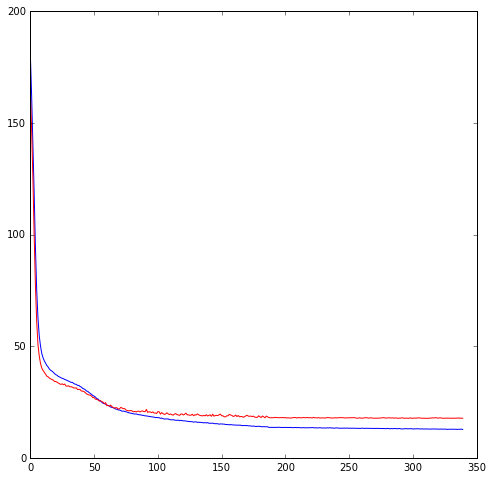

In [949]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [950]:
gen = generate_data_2(test_annotations[200:300], C, max_objs=5)

In [951]:
testdat = [t for t in gen]

In [952]:
Xtest, ytest = testdat[0]

In [953]:
out_fn = theano.function([yl.input], yl.output_test)

In [954]:
Xtest_out = out_fn(Xtest)

In [955]:
def draw_coord(im, coord, idx):
    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    coord[[2,3]] = coord[[2,3]]**2
#     xi = int(im.shape[1] * coord[0])
#     yi = int(im.shape[0] * coord[1])
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)
    
    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    return draw_im

In [956]:
def draw_best(im, output, num=None, thresh=.3):
    im = np.copy(im)
    objectness = output[[4,9]] * output[-C:].max()
    isgreater = objectness[objectness > thresh].size
    idxs = objectness.flatten().argsort()[::-1]
    for i in range(isgreater):
        idx = idxs[i]
        idx = np.unravel_index(idx, objectness.shape)
        coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
        im = draw_coord(im, coord, idx)
        
    return im
        

In [957]:
def draw_best_one(im, output):
    idx = (output[[4,9]]).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    tmp = np.zeros((im.shape[0] + 10, im.shape[1] + 10) + im.shape[2:])
    tmp[5:-5,5:-5] = draw_im
    draw_im = tmp

    return draw_im, obj_score, class_score, coord

In [958]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [959]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [989]:
Xtest, ytest = Xtest[[N]], ytest[[N]]

In [986]:
N = int(Xtest.shape[0] * np.random.rand())
# N = 20
print N
a = draw_best(swap(Xtest[N]), Xtest_out[N], thresh=.2)

86


im = resize(imread('/Users/colingaudreau/car.jpeg'), (200,200))

a = draw_best(im, out_fn(im.reshape((1,) + im.shape).swapaxes(3,2).swapaxes(2,1).astype(theano.config.floatX))[0], thresh=.2)

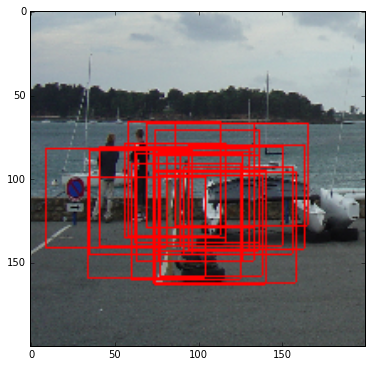

In [987]:
plt.figure(figsize=(6,6))
plt.imshow(a)
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [ ]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)